In [1]:
import matplotlib as mpl
mpl.rcParams['animation.ffmpeg_path'] = '/opt/homebrew/bin/ffmpeg'

In [2]:
import matplotlib as mpl
from matplotlib import animation
print(animation.writers.list())

import numpy as np
import matplotlib.pyplot as plt

#from numpy import *
from matplotlib import rc

rc('font', family='serif', size=14)
rc('lines', linewidth=1.5)

['pillow', 'ffmpeg', 'ffmpeg_file', 'html']


# Forward Simulation

* 1D Eulerian Advection (nonconservative form)
*  u_t + a(x) u_x = 0,  x in [0,L), periodic
* RK4 + first-order upwinding + CFL-based dt
 outputs stored on t_uniform

In [3]:
L = 1.0
N = 600
x_grid = np.linspace(0.0, L, N, endpoint=False)
dx = L / N

CFL = 0.6
tEnd = 1.0
eps = 0.0 # we are not making a(x,t) time-dependent here

# Uniform time grid for output storage
nt_uniform = 500
t_uniform = np.linspace(0.0, tEnd, nt_uniform)

In [4]:
def periodized_gaussian_1d(x, mu, sigma, L):
    return (np.exp(-((x - mu)/sigma)**2)
          + np.exp(-((x - (mu - L))/sigma)**2)
          + np.exp(-((x - (mu + L))/sigma)**2))

### Generating fixed a(x)
we will try for two cases: fixed gaussian a(x) and stochastic a(x) 

In [5]:
# # Static Gaussian advection speed a(x) (known mean/variance)
# mu_a = 0.60 * L
# sigma_a = 0.18 * L
# a_base = 0.55
# a_amp  = 0.55

# a_adv = a_base + a_amp * periodized_gaussian_1d(x_grid, mu_a, sigma_a, L)
# a_adv = np.asarray(a_adv, dtype=np.float64)

In [6]:
# Stochastic a(x)

# Static jointly Gaussian advection speed a(x):
# constant mean + deterministic sine(x) + Gaussian random field w(x)
# w(x) is jointly Gaussian because it is a linear combination of
# Gaussian weights. Periodicity enforced by integer wavenumbers.

rng = np.random.default_rng(7)

a0 = 0.9
amp_sine = 0.25

M = 300            # number of features
sigma_w = 0.12     # std dev scale of stochastic part

# Periodic spatial frequencies: omega_x = 2π k / L
k_int = rng.integers(low=-20, high=21, size=M)
omega_x = 2*np.pi*k_int / L

# Random phases and Gaussian weights
phase = rng.uniform(0.0, 2*np.pi, size=M)
wts = rng.normal(0.0, 1.0, size=M)

# Normalize so Var[w(x)] ~ sigma_w^2 (in expectation)
wts = (sigma_w * np.sqrt(2.0 / M)) * wts

def w_field(xq):
    xq = np.mod(xq, L)
    return np.sum(
        wts[:, None] * np.cos(omega_x[:, None] * xq[None, :] + phase[:, None]),
        axis=0
    )

def a_speed(xq):

    xq = np.mod(xq, L)
    mean_part = a0 + amp_sine * np.sin(2*np.pi * xq / L)
    return mean_part + w_field(xq)

a_adv = a_speed(x_grid)


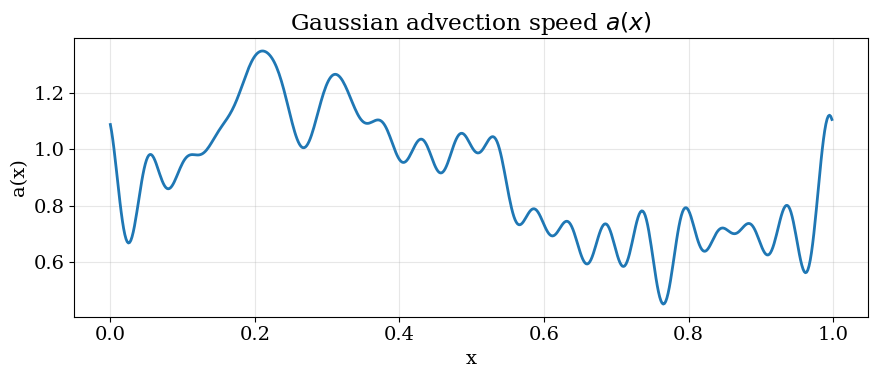

Mean(a) = 0.8940002498185781
Std(a)  = 0.21324561552754911


In [7]:
plt.figure(figsize=(9,4))
plt.plot(x_grid, a_adv, lw=2)
plt.title("Gaussian advection speed $a(x)$")
plt.xlabel("x")
plt.ylabel("a(x)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Mean(a) =", float(np.mean(a_adv)))
print("Std(a)  =", float(np.std(a_adv)))

In [8]:
# First-order upwind derivative (periodic)
def dudx_upwind_first(u, a_vec, dx):
    """
    u: (N,)
    a_vec: (N,) array
    returns u_x using first-order upwind, periodicity ensured using np.roll
    """
    uR = np.roll(u, -1)
    uL = np.roll(u,  1)
    dudx_pos = (u - uL) / dx
    dudx_neg = (uR - u) / dx
    return np.where(a_vec >= 0.0, dudx_pos, dudx_neg)

In [9]:
def rhs(u, a_field, dx, t, eps):
    # eps=0 => a_vec == a_field
    a_vec = a_field * np.exp(-eps * t) # eps = 0
    ux = dudx_upwind_first(u, a_vec, dx)
    return -a_vec * ux

In [10]:
# Single simulation function (RK4 + CFL dt)
def run_single_simulation(u0_1d, x_grid, a_field_1d,CFL, dx, tEnd, t_uniform, eps):

    u       = np.array(u0_1d, dtype=np.float64) # (N,)
    a_field = np.array(a_field_1d, dtype=np.float64)    # (N,)
    N       = u.shape[0]

    
    t_hist = [0.0]
    u_hist = [u.copy()]
    dt_hist = []

    t = 0.0
    while t < tEnd:
        # CFL dt based on max speed
        a_vec = a_field * np.exp(-eps * t)
        a_max = float(np.max(np.abs(a_vec)))

        if a_max > 0.0:
            dt_cfl = CFL * dx / a_max
        else:
            dt_cfl = tEnd - t

        remaining = tEnd - t
        if remaining <= 0.0:
            break

        dt = min(dt_cfl, remaining)
        dt_hist.append(dt)

        # RK4
        k1 = rhs(u,               a_field, dx, t,           eps)
        k2 = rhs(u + 0.5*dt*k1,   a_field, dx, t + 0.5*dt,  eps)
        k3 = rhs(u + 0.5*dt*k2,   a_field, dx, t + 0.5*dt,  eps)
        k4 = rhs(u +       dt*k3, a_field, dx, t + dt,      eps)

        u = u + (dt/6.0) * (k1 + 2*k2 + 2*k3 + k4)
        t = t + dt

        t_hist.append(t)
        u_hist.append(u.copy())

    # Convert histories
    t_hist_np = np.array(t_hist, dtype=np.float64)          # (Nt+1,)
    U_hist_np = np.stack(u_hist, axis=0).astype(np.float64) # (Nt+1, N)
    dt_hist_np = np.array(dt_hist, dtype=np.float64)        # (Nt,)

    # Interpolate to uniform output times
    t_uniform = np.asarray(t_uniform, dtype=np.float64)
    nT = t_uniform.size

    u_uniform = np.empty((N, nT), dtype=np.float64)
    for i in range(N):
        u_uniform[i, :] = np.interp(t_uniform, t_hist_np, U_hist_np[:, i])

    return u_uniform, t_hist_np, U_hist_np, dt_hist_np


# Compressibility of ICs


In [11]:
M = 100 # no. of initial conditions

In [12]:
def periodized_gaussian_batch(x, mu, sigma, L):
    # x: (N,), mu,sigma: (M,)
    X = x[:, None]          # (N,1)
    MU = mu[None, :]        # (1,M)
    S  = sigma[None, :]     # (1,M)
    return (np.exp(-((X - MU)/S)**2)
          + np.exp(-((X - (MU - L))/S)**2)
          + np.exp(-((X - (MU + L))/S)**2))  # (N,M)

In [13]:
rs = np.random.RandomState(300)

mu     = rs.uniform(0.0, L,  size=M)              # U[0,L]
sigma  = rs.uniform(0.025*L, 0.05*L, size=M)      # U[0.025L,0.05L]
amp    = rs.uniform(0.95, 1.0, size=M)            # U[0.95,1.0]

mu = np.asarray(mu)
sigma = np.asarray(sigma)
amp = np.asarray(amp)

g = periodized_gaussian_batch(x_grid, mu, sigma, L)     # (N,M)
u0_mat = 1.0 + (g * amp[None, :])                      # (N,M)
u0_mat = np.asarray(u0_mat, dtype=np.float64)

In [14]:
# SVD + 99.99% energy rank
def svd_energy_rank(A, energy=0.9999):
    U, S, Vh = np.linalg.svd(A, full_matrices=False)
    s2 = S**2
    cum = np.cumsum(s2)
    r = int(np.searchsorted(cum, energy * s2.sum()) + 1)
    U_r = U[:, :r]
    return r, U_r, S

In [15]:
r_u0, U_u0, S_u0 = svd_energy_rank(u0_mat, energy=0.9999)
print("Ranks for 99.99% cumulative energy:")
print("  u0   :", float(r_u0))

Ranks for 99.99% cumulative energy:
  u0   : 28.0


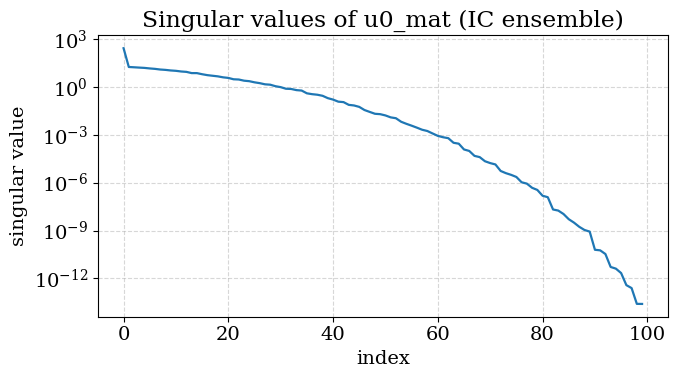

In [16]:
plt.figure(figsize=(7,4))
plt.semilogy(S_u0, lw=1.6)
plt.title("Singular values of u0_mat (IC ensemble)")
plt.xlabel("index")
plt.ylabel("singular value")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()

# Run All Simulation Parallel

In [17]:
from joblib import Parallel, delayed

In [18]:
def run_all_simulations_parallel(u0_mat, x_grid, a_adv,
                                 CFL, dx, tEnd, t_uniform,
                                 eps,               # <-- NEW
                                 n_jobs=-1):
    """
    Run one advection simulation per initial condition (column of u0_mat)
    in parallel using joblib.

    PDE: u_t + a(x,t) u_x = 0, periodic BC.
         a(x,t) = a_adv(x) * exp(-eps * t)

    a_adv(x) is a single, precomputed advection field shared by all ICs.
    """
    N, M = u0_mat.shape
    print(f"Launching {M} independent simulations using {n_jobs} workers...")

    # ---- Ensure data are NumPy arrays for joblib ----
    u0_mat_host = np.asarray(u0_mat)
    a_adv_host  = np.asarray(a_adv)
    x_grid_host = np.asarray(x_grid)

    # Inside joblib we are on CPU / NumPy
    results = Parallel(n_jobs=n_jobs, verbose=10)(
        delayed(run_single_simulation)(
            u0_mat_host[:, m],   # IC m (size N)
            x_grid_host,         # grid
            a_adv_host,          # same advection field for all ICs
            CFL, dx, tEnd, t_uniform,
            eps                  # <-- pass eps through
        )
        for m in range(M)
    )

    # Each result: (u_uniform, t_hist, U_hist, dt_hist)
    u_uniform_list, t_hist_list, U_hist_list, dt_hist_list = zip(*results)

    print("\nSimulation summary:")
    for i, dt_hist in enumerate(dt_hist_list):
        # if dt_hist[0] = 0.0 and has length Nt+1:
        nsteps = len(dt_hist) - 1
        print(f"  IC {i:3d}: {nsteps:5d} time steps")

    return (list(u_uniform_list),
            list(t_hist_list),
            list(U_hist_list),
            list(dt_hist_list))

In [19]:
# Suppose you already built u0_mat (N, M) with periodized_gaussian_batch

N, M = u0_mat.shape
dx = L / N
tEnd = 1.0
t_uniform = np.linspace(0.0, tEnd, 100)

# Build Eulerian grid if not already
x_grid = np.linspace(0.0, L, N, endpoint=False)
#a_adv = a_field    # (N,) precomputed advection speed

# a_adv should be defined earlier, e.g.
# a_adv = some_function_of_x(x_grid)

u_uniform_list, t_hist_list, U_hist_list, dt_hist_list = run_all_simulations_parallel(
    u0_mat,           # (N, M)
    x_grid,           # (N,)
    a_adv,            # (N,) precomputed advection speed
    CFL=CFL,
    dx=dx,
    tEnd=tEnd,
    t_uniform=t_uniform,
    eps=eps,          # <-- pass eps through
    n_jobs=-1
)

print(f"Completed {len(u_uniform_list)} simulations.")
print("u_uniform shape  IC 0:", u_uniform_list[0].shape)   # (N, nT)
print("t_hist shape     IC 0:", t_hist_list[0].shape)      # (Nt+1,)
print("U_hist shape     IC 0:", U_hist_list[0].shape)      # (Nt+1, N)
print("dt_hist shape    IC 0:", dt_hist_list[0].shape)     # (Nt,)

Launching 100 independent simulations using -1 workers...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    2.1s



Simulation summary:
  IC   0:  1347 time steps
  IC   1:  1347 time steps
  IC   2:  1347 time steps
  IC   3:  1347 time steps
  IC   4:  1347 time steps
  IC   5:  1347 time steps
  IC   6:  1347 time steps
  IC   7:  1347 time steps
  IC   8:  1347 time steps
  IC   9:  1347 time steps
  IC  10:  1347 time steps
  IC  11:  1347 time steps
  IC  12:  1347 time steps
  IC  13:  1347 time steps
  IC  14:  1347 time steps
  IC  15:  1347 time steps
  IC  16:  1347 time steps
  IC  17:  1347 time steps
  IC  18:  1347 time steps
  IC  19:  1347 time steps
  IC  20:  1347 time steps
  IC  21:  1347 time steps
  IC  22:  1347 time steps
  IC  23:  1347 time steps
  IC  24:  1347 time steps
  IC  25:  1347 time steps
  IC  26:  1347 time steps
  IC  27:  1347 time steps
  IC  28:  1347 time steps
  IC  29:  1347 time steps
  IC  30:  1347 time steps
  IC  31:  1347 time steps
  IC  32:  1347 time steps
  IC  33:  1347 time steps
  IC  34:  1347 time steps
  IC  35:  1347 time steps
  IC  3

[Parallel(n_jobs=-1)]: Done  96 out of 100 | elapsed:    2.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.4s finished


In [20]:
x_grid.shape

(600,)

In [21]:
u_hist_param = u_uniform_list
u_hist_param[2].shape

(600, 100)

In [22]:
u_hist_tensor = np.asarray(u_hist_param, dtype=np.float64)

In [23]:
u_hist_tensor.shape

(100, 600, 100)

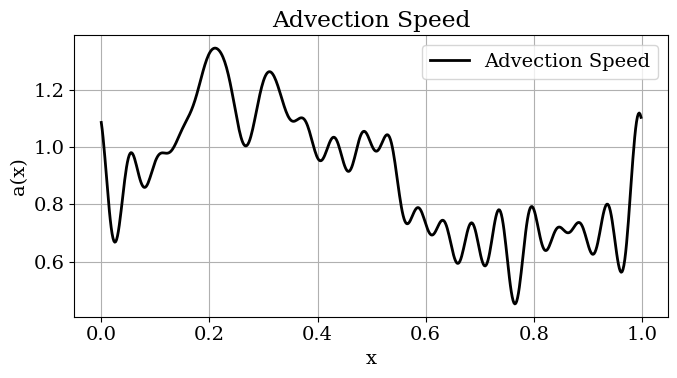

In [24]:
plt.figure(figsize=(7,4))
plt.plot(x_grid, a_adv, 'k-', lw=2, label='Advection Speed')
plt.xlabel('x')
plt.ylabel('a(x)')
plt.title('Advection Speed')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [25]:
# We are checking local compression for 200th timestep out of 500 timesteps

u_local = np.transpose(u_hist_tensor[:,:, 99])
r_u,   U_u,   S_u   = svd_energy_rank(u_local)

# ---- report (bring tiny scalars to host for printing if on GPU) ----
to_host = (lambda v: float(v))
print("Ranks for 99.99% cumulative energy:")

print("  u    :", to_host(r_u))

Ranks for 99.99% cumulative energy:
  u    : 13.0


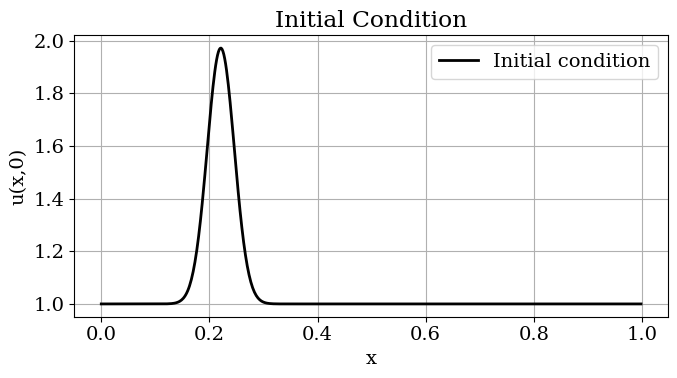

In [26]:
plt.figure(figsize=(7,4))
plt.plot(x_grid, u_hist_tensor[1, :, 0 ], 'k-', lw=2, label='Initial condition')
plt.xlabel('x')
plt.ylabel('u(x,0)')
plt.title('Initial Condition')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Observation:
If we change the timestep values, the rank does not change. Becuase nothing interesting is happening. everything is just moving to the right.

## Build local basis at each timestep.

In [27]:
r = 15
nt = t_uniform.shape[0]

# history tensors: (nx, M, nt)
results_u   = []
Vr_u_hist   = []
u_hat_hist = []

for it in range(nt):
    # Take snapshot matrices across all ICs at a given time
    u_local   = np.transpose(u_hist_tensor[:, :, it])

    U_u,   _,   _ = np.linalg.svd(u_local)#,   full_matrices=False)

    Vr_u   = U_u[:, :r]
    u_hat = Vr_u.T @ u_local
    Vr_u_hist.append(Vr_u)
    u_hat_hist.append(u_hat)

In [28]:
u_hat.shape

(15, 100)

## Calculate Misalignment between two local POD bases

In [29]:
def subspace_drift(V_hist):
    nt = len(V_hist)
    E_minus = np.zeros(nt)
    E_plus  = np.zeros(nt)
    I = np.eye(V_hist[0].shape[0], dtype=V_hist[0].dtype)

    for i in range(nt):
        V_curr = V_hist[i]

        # previous projection
        if i > 0:
            V_prev = V_hist[i - 1]
            P_prev = V_prev @ V_prev.T
            E_minus[i] = np.linalg.norm((I - P_prev) @ V_curr, 'fro')
        else:
            E_minus[i] = np.nan  # no previous step

        # next projection
        if i < nt - 1:
            V_next = V_hist[i + 1]
            P_next = V_next @ V_next.T
            E_plus[i] = np.linalg.norm((I - P_next) @ V_curr, 'fro')
        else:
            E_plus[i] = np.nan  # no next step

    return E_minus, E_plus

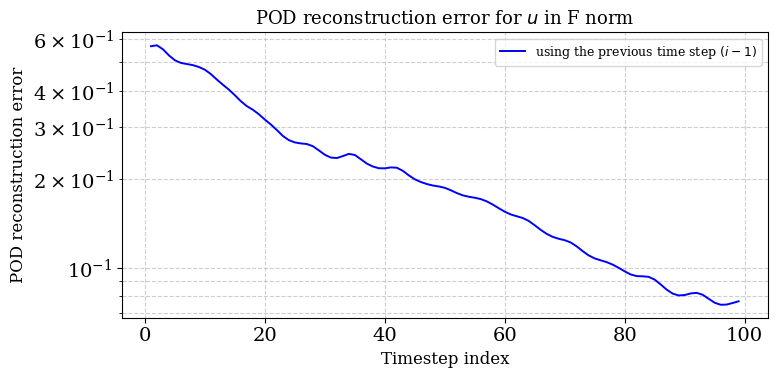

In [30]:
Eminus_u, Eplus_u = subspace_drift(Vr_u_hist)

fields = [
    (Eminus_u, Eplus_u, r'$u$'),
]

for (Eminus, Eplus, field_label) in fields:
    plt.figure(figsize=(8, 4))
    plt.semilogy(Eminus, 'b-', lw=1.4,
                 label=fr"using the previous time step $(i-1)$")
    # plt.semilogy(Eplus, 'r--', lw=1.4,
    #              label=fr"using the next time step $(i+1)$")

    plt.xlabel("Timestep index", fontsize=12)
    plt.ylabel("POD reconstruction error", fontsize=12)
    plt.title(fr"POD reconstruction error for {field_label} in F norm",
              fontsize=13)
    plt.grid(True, which='both', linestyle='--', alpha=0.6)
    plt.legend(fontsize=9)
    plt.tight_layout()
    plt.show()

# Quick Check to see if the interpolation scheme actually work or not

In [ ]:
# ------------------------------------------------------------
# Periodic linear interpolation on uniform grid [0,L)
# ------------------------------------------------------------
def interp_periodic_on_grid(values_on_grid, xq, L):
    """
    values_on_grid: (N,)
    xq: array-like points in [0,L) (will be modded)
    """
    v = np.asarray(values_on_grid)
    xq = np.mod(np.asarray(xq), L)
    N = v.size
    dx = L / N
    i0 = np.floor(xq / dx).astype(int) % N
    frac = (xq - i0*dx) / dx
    return (1 - frac) * v[i0] + frac * v[(i0 + 1) % N]

# ------------------------------------------------------------
# Fix 3: departure points for general a(x) stored on grid
# Backward-Euler in space: x_dep = x_arr - dt * a(x_dep) * exp(-eps*t_arr)
# ------------------------------------------------------------
def departure_points_BE_from_avec(a_vec, x_arr, dt, L, t_arrival, eps,
                                 n_iter=30, tol=1e-12):
    x_arr = np.asarray(x_arr)
    fac = np.exp(-eps * t_arrival)

    # initial guess: explicit backtrace using a(x_arr)
    a_at_x = interp_periodic_on_grid(a_vec, x_arr, L)
    xdep = (x_arr - dt * a_at_x * fac) % L

    for _ in range(n_iter):
        a_at_xdep = interp_periodic_on_grid(a_vec, xdep, L)
        xnew = (x_arr - dt * a_at_xdep * fac) % L
        if np.max(np.abs(xnew - xdep)) < tol:
            xdep = xnew
            break
        xdep = xnew
    return xdep

# ------------------------------------------------------------
# Apply T_k(a) to snapshot matrix Uk (supports (N,M) or (M,N))
# ------------------------------------------------------------
def apply_shift_to_snapshots(Uk, x_dep, L):
    Uk = np.asarray(Uk)
    x_dep = np.asarray(x_dep)

    # (N,M)
    if Uk.shape[0] == x_dep.size:
        N, M = Uk.shape
        TUk = np.empty_like(Uk)
        for m in range(M):
            TUk[:, m] = interp_periodic_on_grid(Uk[:, m], x_dep, L)
        return TUk

    # (M,N)
    if Uk.shape[1] == x_dep.size:
        M, N = Uk.shape
        TUk = np.empty_like(Uk)
        for m in range(M):
            TUk[m, :] = interp_periodic_on_grid(Uk[m, :], x_dep, L)
        return TUk

    raise ValueError(f"Uk shape {Uk.shape} incompatible with x_dep length {x_dep.size}")

In [ ]:
For i in range(nt):
    u_hat_true [i] = 

# Inverting for a(x)

## Attempt 1: Using the original objective function, no regularization, not assuming any structure of a(x)

In [56]:
import time
from scipy.optimize import minimize

In [57]:
# Periodic linear interpolation on uniform grid [0,L)
def interp_periodic_on_grid(values_on_grid, xq, L):
    v = np.asarray(values_on_grid)
    xq = np.mod(np.asarray(xq), L)
    N = v.size
    dx = L / N
    i0 = np.floor(xq / dx).astype(int) % N
    frac = (xq - i0 * dx) / dx
    return (1 - frac) * v[i0] + frac * v[(i0 + 1) % N]

In [58]:
# Departure points: backward Euler in x, solved by fixed-point iteration
#  x_dep = x - dt * a(x_dep) * exp(-eps * t_arrival)
# in this case, eps = 0
def departure_points_backward_euler(a_vec, x_grid, dt, L, t_arrival, eps,
                                    n_iter=30, tol=1e-12):
    x = np.asarray(x_grid)
    fac = np.exp(-eps * t_arrival)

    # initial guess: explicit Euler backtrace using a(x_arrival)
    a_at_x = interp_periodic_on_grid(a_vec, x, L)
    xdep = (x - dt * a_at_x * fac) % L

    for _ in range(n_iter):
        a_at_xdep = interp_periodic_on_grid(a_vec, xdep, L)
        xnew = (x - dt * a_at_xdep * fac) % L
        if np.max(np.abs(xnew - xdep)) < tol:
            xdep = xnew
            break
        xdep = xnew

    return xdep

In [59]:
# Apply T_k(a) to each column of Vk
def apply_shift_to_basis(Vk, x_dep, L):
    Vk = np.asarray(Vk)
    N, r = Vk.shape
    S_Vk = np.empty_like(Vk)
    for j in range(r):
        S_Vk[:, j] = interp_periodic_on_grid(Vk[:, j], x_dep, L)
    return S_Vk

In [60]:
# Objective: minimize negative Fro^2 of projected operator
# J(a_vec) = -|| V_{k+1}^T T_k(a_vec) V_k ||_F^2
def objective_neg_fro2(a_vec, Vk, Vkp1, x_grid, dt, L, t_arrival, eps):
    x_dep = departure_points_backward_euler(a_vec, x_grid, dt, L, t_arrival, eps)
    S_Vk = apply_shift_to_basis(Vk, x_dep, L)
    Ared = Vkp1.T @ S_Vk
    return -np.linalg.norm(Ared, ord="fro")**2

In [61]:
# # Inversion per timestep
# def invert_a_per_timestep_nonparametric(x_grid, L, t_uniform, Vr_u_hist, eps, a_init, 
#                                         a_bounds=(0.0, 3.0), maxiter=60, ftol=1e-10,true_a=None):
#     x_grid = np.asarray(x_grid)
#     N = x_grid.size
#     K = len(t_uniform)
#     dt_k = float(t_uniform[1] - t_uniform[0])

#     a_hat_hist = np.zeros((K-1, N), dtype=float)
#     rel_err_hist = np.full(K-1, np.nan, dtype=float)

#     bounds = [a_bounds] * N

#     if true_a is not None:
#         true_a = np.asarray(true_a, dtype=float)
#         dx = L / N
#         denom = np.sqrt(np.sum(true_a**2) * dx) + 1e-14
#     else:
#         denom = None

#     a_prev = np.asarray(a_init, dtype=float).copy()

#     for k in range(K-1):
#         Vk = Vr_u_hist[k]
#         Vkp1 = Vr_u_hist[k+1]
#         t_arrival = float(t_uniform[k+1])

#         res = minimize(
#             objective_neg_fro2,
#             x0=a_prev,
#             args=(Vk, Vkp1, x_grid, dt_k, L, t_arrival, eps),
#             method="L-BFGS-B",
#             bounds=bounds,
#             jac="2-point",  #finite-difference gradient
#             options={"maxiter": maxiter, "ftol": ftol}
#         )

#         a_hat = res.x
#         a_hat_hist[k, :] = a_hat

#         if true_a is not None:
#             dx = L / N
#             num = np.sqrt(np.sum((a_hat - true_a)**2) * dx)
#             rel_err_hist[k] = num / denom

#         # warm-start for next k
#         a_prev = a_hat

#     return a_hat_hist, rel_err_hist


### for a single timestep

In [62]:

def invert_a_single_timestep_nonparametric(k_solve, x_grid, L, t_uniform, Vr_u_hist, eps, a_init,
                                            a_bounds=(0.0, 3.0), maxiter=25, ftol=1e-10, verbose=True):
    x_grid = np.asarray(x_grid)
    N = x_grid.size
    K = len(t_uniform)
    if not (0 <= k_solve <= K - 2):
        raise ValueError(f"k_solve must be in [0, {K-2}], got {k_solve}")

    dt = float(t_uniform[1] - t_uniform[0])
    t_arrival = float(t_uniform[k_solve + 1])

    Vk = Vr_u_hist[k_solve]
    Vkp1 = Vr_u_hist[k_solve + 1]

    bounds = [a_bounds] * N
    a0 = np.asarray(a_init, dtype=float).copy()

    t0 = time.perf_counter()
    res = minimize(
        objective_neg_fro2,
        x0=a0,
        args=(Vk, Vkp1, x_grid, dt, L, t_arrival, eps),
        method="L-BFGS-B",
        bounds=bounds,
        jac="2-point",
        options={"maxiter": maxiter, "ftol": ftol}
    )
    t1 = time.perf_counter()

    if verbose:
        print(f"[single-k] k={k_solve} | success={res.success} | "
              f"iters={res.nit} | fval={res.fun:.3e} | time={t1-t0:.2f}s")

    return res.x, float(res.fun), (t1 - t0), bool(res.success), int(res.nit)


[single-k] k=50 | success=False | iters=7 | fval=-1.510e+01 | time=9.52s


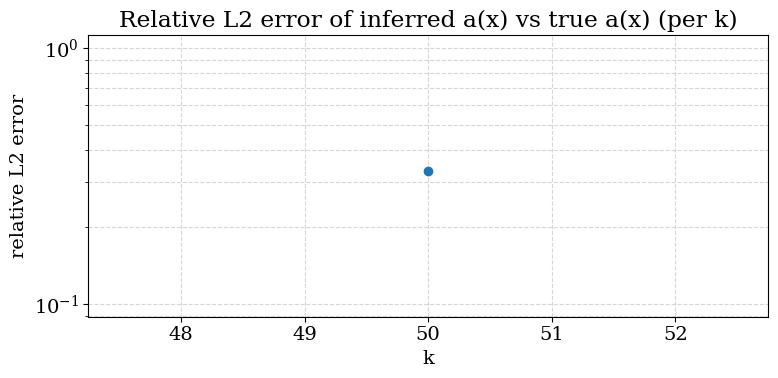

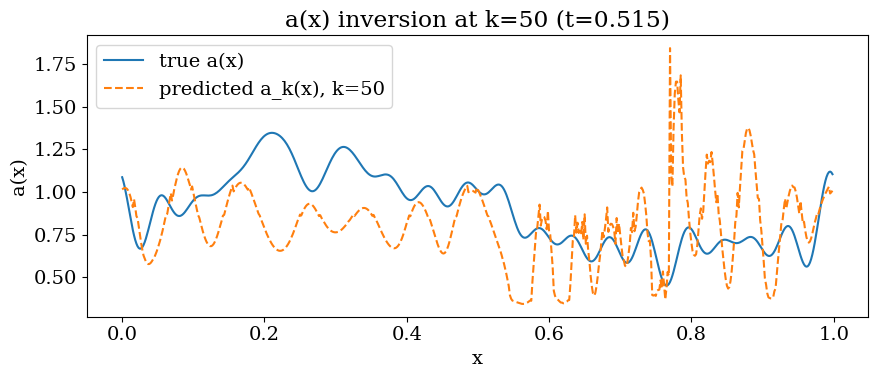

k_plot=50
rel_err=3.295e-01


In [63]:
def package_single_k_results_for_plots(
    k_solve,
    a_hat_k,
    x_grid, L, t_uniform,
    true_a=None
):
    """
    Build full-shaped arrays like the multi-k routine returns:
      a_hat_hist: (K-1, N) but only row k_solve filled (others NaN)
      rel_err_hist: (K-1,) but only entry k_solve filled if true_a is given
    """
    K = len(t_uniform)
    N = len(x_grid)

    a_hat_hist = np.full((K - 1, N), np.nan, dtype=float)
    rel_err_hist = np.full(K - 1, np.nan, dtype=float)

    a_hat_hist[k_solve, :] = np.asarray(a_hat_k, dtype=float)

    if true_a is not None:
        true_a = np.asarray(true_a, dtype=float)
        dx = L / N
        denom = np.sqrt(np.sum(true_a**2) * dx) + 1e-14
        num = np.sqrt(np.sum((a_hat_k - true_a)**2) * dx)
        rel_err_hist[k_solve] = num / denom

    return a_hat_hist, rel_err_hist


def plot_single_k_results(
    k_plot,
    x_grid, L, t_uniform,
    a_hat_hist,
    rel_err_hist=None,
    true_a=None
):
    """
    Same plots you used before:
      (1) rel_err vs k  (will show one dot if you solved only one timestep)
      (2) a_true vs a_pred for chosen k_plot
    """
    k_plot = int(np.clip(k_plot, 0, len(t_uniform) - 2))

    # (1) error vs k
    if rel_err_hist is not None:
        plt.figure(figsize=(8, 4))
        plt.semilogy(rel_err_hist + 1e-18, marker="o")
        plt.title("Relative L2 error of inferred a(x) vs true a(x) (per k)")
        plt.xlabel("k")
        plt.ylabel("relative L2 error")
        plt.grid(True, which="both", ls="--", alpha=0.5)
        plt.tight_layout()
        plt.show()

    # (2) profile plot at k_plot
    a_pred = a_hat_hist[k_plot, :]
    plt.figure(figsize=(9, 4))
    if true_a is not None:
        plt.plot(x_grid, true_a, label="true a(x)")
    plt.plot(x_grid, a_pred, "--", label=f"predicted a_k(x), k={k_plot}")
    plt.title(f"a(x) inversion at k={k_plot} (t={t_uniform[k_plot+1]:.3f})")
    plt.xlabel("x")
    plt.ylabel("a(x)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Print
    print(f"k_plot={k_plot}")
    if rel_err_hist is not None and np.isfinite(rel_err_hist[k_plot]):
        print(f"rel_err={rel_err_hist[k_plot]:.3e}")



# Pick one timestep
k_solve = 50  # <--- set this

# Initial guess for a(x)
a_init = 0.8 * np.ones_like(x_grid)

# Solve single-k
a_hat_k, fval, sec, ok, nit = invert_a_single_timestep_nonparametric(
    k_solve=k_solve,
    x_grid=x_grid, L=L, t_uniform=t_uniform, Vr_u_hist=Vr_u_hist, eps=eps,
    a_init=a_init,
    a_bounds=(0.0, 3.0),
    maxiter=25,
    ftol=1e-10,
    verbose=True
)

# Package into full-shaped arrays for the SAME plots
# If you have a true a(x) vector on the grid, pass it as true_a (else None)
a_hat_hist, rel_err_hist = package_single_k_results_for_plots(
    k_solve=k_solve,
    a_hat_k=a_hat_k,
    x_grid=x_grid, L=L, t_uniform=t_uniform,
    true_a=a_adv  # <-- change to your true a(x) or set None
)

# Make the same plots (error-vs-k + profile)
plot_single_k_results(
    k_plot=k_solve,
    x_grid=x_grid, L=L, t_uniform=t_uniform,
    a_hat_hist=a_hat_hist,
    rel_err_hist=rel_err_hist,
    true_a=a_adv  # <-- same as above, or None
)


### the following code runs forever

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# AFTER you run:
#a_hat_hist, rel_err_hist = invert_a_per_timestep_nonparametric(...)
# Initial guess for a(x)
a0 = 0.8 * np.ones_like(x_grid)

# If you know the true a(x) on the grid (optional)
a_true = a_adv   # <-- replace with your true grid vector if you have it

a_hat_hist, rel_err_hist = invert_a_per_timestep_nonparametric(
    x_grid=x_grid,
    L=L,
    t_uniform=t_uniform,
    Vr_u_hist=Vr_u_hist,
    eps=eps,
    a_init=a0,
    a_bounds=(0.0, 3.0),
    maxiter=60,
    ftol=1e-10,
    true_a=a_true
)

# then run the plotting cell above

# ---- error vs k plot ----
plt.figure(figsize=(8, 4))
plt.semilogy(rel_err_hist + 1e-18)
plt.title("Relative L2 error of inferred a_k(x) vs true a(x) (per k)")
plt.xlabel("k")
plt.ylabel("relative L2 error")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()

# ---- demo plot: choose k_plot (changeable) ----
k_plot = 10   # <--- YOU CAN CHANGE THIS
k_plot = int(np.clip(k_plot, 0, len(t_uniform) - 2))

# If you have a known true a(x) vector, define it (same grid as x_grid)
# Example:
# a_true = a_adv                      # your true grid vector
# OR:
# a_true = some_known_function(x_grid)

# If you passed true_a=... into the inversion, reuse that same array here:
# a_true = np.asarray(true_a)

a_pred = a_hat_hist[k_plot]

plt.figure(figsize=(9, 4))
if 'a_true' in globals() and a_true is not None:
    plt.plot(x_grid, a_true, label="true a(x)")
plt.plot(x_grid, a_pred, "--", label=f"predicted a_k(x), k={k_plot}")

plt.title(f"a(x) inversion demo at k={k_plot} (t={t_uniform[k_plot+1]:.3f})")
plt.xlabel("x")
plt.ylabel("a(x)")
plt.legend()
plt.tight_layout()
plt.show()

# ---- print diagnostics ----
print(f"k_plot={k_plot}")
if rel_err_hist is not None and np.isfinite(rel_err_hist[k_plot]):
    print(f"rel_err={rel_err_hist[k_plot]:.3e}")

# Optional: show whether inferred a is "changing" across time
# (norm of difference between consecutive inferred profiles)
dx = L / x_grid.size
delta_norm = np.sqrt(np.sum((a_hat_hist[1:] - a_hat_hist[:-1])**2, axis=1) * dx)

plt.figure(figsize=(8, 4))
plt.semilogy(delta_norm + 1e-18)
plt.title("Change in inferred a_k(x) between timesteps (L2)")
plt.xlabel("k (between k and k+1)")
plt.ylabel(r"$\|a_{k+1}-a_k\|_{L^2}$")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()


## Attempt1 but with H1 regularization

In [64]:
def interp_periodic_on_grid(values_on_grid, xq, L):
    v = np.asarray(values_on_grid)
    xq = np.mod(np.asarray(xq), L)
    N = v.size
    dx = L / N
    i0 = np.floor(xq / dx).astype(int) % N
    frac = (xq - i0 * dx) / dx
    return (1 - frac) * v[i0] + frac * v[(i0 + 1) % N]

In [ ]:
def departure_points_backward_euler(a_vec, x_grid, dt, L, t_arrival, eps,
                                    n_iter=30, tol=1e-12):
    x = np.asarray(x_grid)
    fac = np.exp(-eps * t_arrival)

    # initial guess: explicit Euler backtrace using a(x_arrival)
    a_at_x = interp_periodic_on_grid(a_vec, x, L)
    xdep = (x - dt * a_at_x * fac) % L

    for _ in range(n_iter):
        a_at_xdep = interp_periodic_on_grid(a_vec, xdep, L)
        xnew = (x - dt * a_at_xdep * fac) % L
        if np.max(np.abs(xnew - xdep)) < tol:
            xdep = xnew
            break
        xdep = xnew

    return xdep

In [ ]:
def apply_shift_to_basis(Vk, x_dep, L):
    Vk = np.asarray(Vk)
    N, r = Vk.shape
    S_Vk = np.empty_like(Vk)
    for j in range(r):
        S_Vk[:, j] = interp_periodic_on_grid(Vk[:, j], x_dep, L)
    return S_Vk

In [ ]:
def H1_penalty(a_vec, dx):
    da = (np.roll(a_vec, -1) - a_vec) / dx
    return np.sum(da**2) * dx

In [ ]:
# Objective (minimize):-|| V_{k+1}^T T_k(a) V_k ||_F^2  + lam_H1 * ||a_x||_2^2
def objective_neg_fro2_H1(a_vec, Vk, Vkp1, x_grid, dt, L, t_arrival, eps, lam_H1):
    x_dep = departure_points_backward_euler(a_vec, x_grid, dt, L, t_arrival, eps)
    S_Vk = apply_shift_to_basis(Vk, x_dep, L)
    Ared = Vkp1.T @ S_Vk

    data_term = -np.linalg.norm(Ared, ord="fro")**2

    dx = L / x_grid.size
    reg_term = lam_H1 * H1_penalty(a_vec, dx)

    return data_term + reg_term

In [ ]:
# Per-k inversion wrapper WITH H1 REG
def invert_a_per_timestep_nonparametric_H1(
    x_grid, L, t_uniform, Vr_u_hist, eps,
    a_init,                    # (N,) initial guess for a(x)
    a_bounds=(0.0, 3.0),        # box constraints applied to each entry
    lam_H1=1e-4,                # <-- NEW
    maxiter=60,
    ftol=1e-10,
    true_a=None                 # optional (N,) for error computation
):
    x_grid = np.asarray(x_grid)
    N = x_grid.size
    K = len(t_uniform)
    dt_k = float(t_uniform[1] - t_uniform[0])

    a_hat_hist = np.zeros((K-1, N), dtype=float)
    rel_err_hist = np.full(K-1, np.nan, dtype=float)

    bounds = [a_bounds] * N

    if true_a is not None:
        true_a = np.asarray(true_a, dtype=float)
        dx = L / N
        denom = np.sqrt(np.sum(true_a**2) * dx) + 1e-14
    else:
        denom = None

    a_prev = np.asarray(a_init, dtype=float).copy()

    for k in range(K-1):
        Vk = Vr_u_hist[k]
        Vkp1 = Vr_u_hist[k+1]
        t_arrival = float(t_uniform[k+1])

        res = minimize(
            objective_neg_fro2_H1,
            x0=a_prev,
            args=(Vk, Vkp1, x_grid, dt_k, L, t_arrival, eps, lam_H1),
            method="L-BFGS-B",
            bounds=bounds,
            jac="2-point",  # finite-diff gradient
            options={"maxiter": maxiter, "ftol": ftol}
        )

        a_hat = res.x
        a_hat_hist[k, :] = a_hat

        if true_a is not None:
            dx = L / N
            num = np.sqrt(np.sum((a_hat - true_a)**2) * dx)
            rel_err_hist[k] = num / denom

        a_prev = a_hat  # warm-start

    return a_hat_hist, rel_err_hist


[single-k] k=50 | success=False | iters=6 | fval=-1.511e+01 | time=10.54s


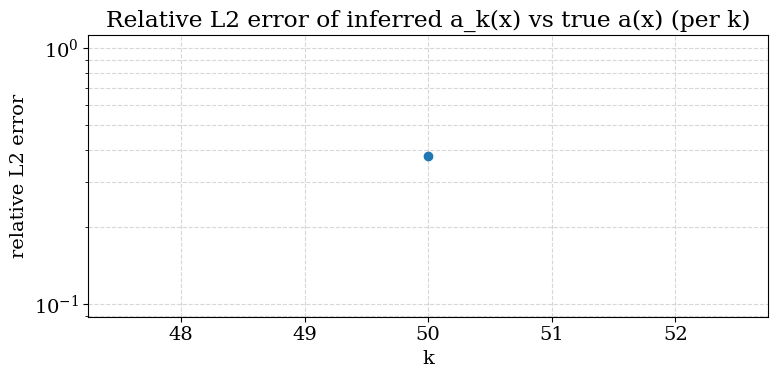

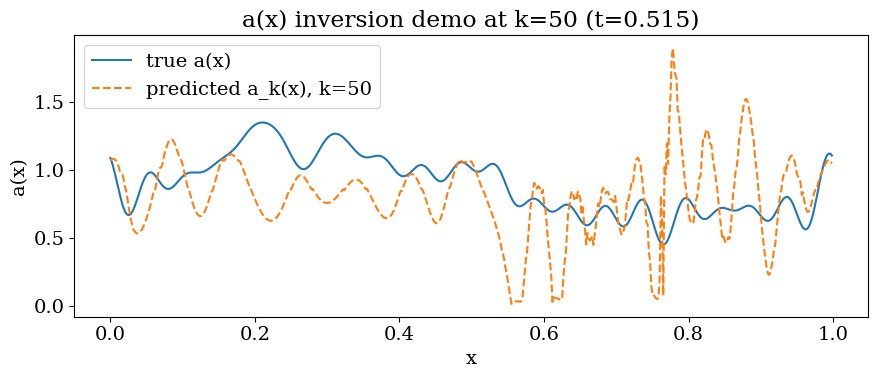

k_plot=50
rel_err=3.801e-01


In [37]:
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# ============================================================
# (Assumes these functions already exist in your notebook)
#   - interp_periodic_on_grid
#   - departure_points_backward_euler
#   - apply_shift_to_basis
#   - H1_penalty
#   - objective_neg_fro2_H1
# ============================================================

def invert_a_single_timestep_nonparametric_H1(
    k_solve,
    x_grid, L, t_uniform, Vr_u_hist, eps,
    a_init,
    a_bounds=(0.0, 3.0),
    lam_H1=5e-4,
    maxiter=25,
    ftol=1e-10,
    verbose=True
):
    """
    Solve ONE timestep k_solve for the nonparametric field a(x) on the grid:

      min_{a in R^N}  -|| V_{k+1}^T T_k(a) V_k ||_F^2  + lam_H1 * ||a_x||_2^2
      subject to: a_bounds[0] <= a_i <= a_bounds[1]

    Returns:
      a_hat (N,), fval, elapsed_sec, success_flag, nit
    """
    x_grid = np.asarray(x_grid)
    N = x_grid.size
    K = len(t_uniform)
    if not (0 <= k_solve <= K - 2):
        raise ValueError(f"k_solve must be in [0, {K-2}], got {k_solve}")

    dt = float(t_uniform[1] - t_uniform[0])
    t_arrival = float(t_uniform[k_solve + 1])

    Vk = Vr_u_hist[k_solve]
    Vkp1 = Vr_u_hist[k_solve + 1]

    bounds = [a_bounds] * N
    a0 = np.asarray(a_init, dtype=float).copy()

    t0 = time.perf_counter()
    res = minimize(
        objective_neg_fro2_H1,
        x0=a0,
        args=(Vk, Vkp1, x_grid, dt, L, t_arrival, eps, lam_H1),
        method="L-BFGS-B",
        bounds=bounds,
        jac="2-point",  # finite-difference gradient
        options={"maxiter": maxiter, "ftol": ftol}
    )
    t1 = time.perf_counter()

    if verbose:
        print(f"[single-k] k={k_solve} | success={res.success} | "
              f"iters={res.nit} | fval={res.fun:.3e} | time={t1-t0:.2f}s")

    return res.x, float(res.fun), (t1 - t0), bool(res.success), int(res.nit)


def package_single_k_results_for_plots(
    k_solve,
    a_hat_k,
    x_grid, L, t_uniform,
    true_a=None
):
    """
    Create a_hat_hist and rel_err_hist shaped like the full run,
    but only filled at index k_solve. Others are NaN, so your
    existing plots still work.
    """
    K = len(t_uniform)
    N = len(x_grid)

    a_hat_hist = np.full((K-1, N), np.nan, dtype=float)
    rel_err_hist = np.full(K-1, np.nan, dtype=float)

    a_hat_hist[k_solve, :] = np.asarray(a_hat_k, dtype=float)

    if true_a is not None:
        true_a = np.asarray(true_a, dtype=float)
        dx = L / N
        denom = np.sqrt(np.sum(true_a**2) * dx) + 1e-14
        num = np.sqrt(np.sum((a_hat_k - true_a)**2) * dx)
        rel_err_hist[k_solve] = num / denom

    return a_hat_hist, rel_err_hist


def plot_single_k_diagnostics(
    k_plot,
    x_grid, t_uniform,
    a_hat_hist,
    rel_err_hist=None,
    true_a=None,
    L=None
):
    """
    Plots:
      1) rel_err vs k (will show one point if only one k solved)
      2) a_true vs a_pred at k_plot
      3) optional: consecutive-change plot if you solved >1 k (otherwise blank)
    """
    # --- error vs k ---
    if rel_err_hist is not None:
        plt.figure(figsize=(8, 4))
        plt.semilogy(rel_err_hist + 1e-18, marker="o")
        plt.title("Relative L2 error of inferred a_k(x) vs true a(x) (per k)")
        plt.xlabel("k")
        plt.ylabel("relative L2 error")
        plt.grid(True, which="both", ls="--", alpha=0.5)
        plt.tight_layout()
        plt.show()

    # --- a(x) profile at k_plot ---
    a_pred = a_hat_hist[k_plot]
    plt.figure(figsize=(9, 4))
    if true_a is not None:
        plt.plot(x_grid, true_a, label="true a(x)")
    plt.plot(x_grid, a_pred, "--", label=f"predicted a_k(x), k={k_plot}")
    plt.title(f"a(x) inversion demo at k={k_plot} (t={t_uniform[k_plot+1]:.3f})")
    plt.xlabel("x")
    plt.ylabel("a(x)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- print diagnostics ---
    print(f"k_plot={k_plot}")
    if rel_err_hist is not None and np.isfinite(rel_err_hist[k_plot]):
        print(f"rel_err={rel_err_hist[k_plot]:.3e}")

    # --- optional: change in inferred a between timesteps ---
    # Only meaningful if multiple rows are not NaN.
    if L is not None:
        mask = np.isfinite(a_hat_hist[:, 0])
        idx = np.where(mask)[0]
        if len(idx) >= 2:
            dx = L / len(x_grid)
            deltas = []
            ks = []
            for i in range(len(idx) - 1):
                k0, k1 = idx[i], idx[i+1]
                da = a_hat_hist[k1] - a_hat_hist[k0]
                deltas.append(np.sqrt(np.sum(da**2) * dx))
                ks.append(k0)
            plt.figure(figsize=(8, 4))
            plt.semilogy(ks, np.asarray(deltas) + 1e-18, marker="o")
            plt.title("Change in inferred a between solved timesteps (L2)")
            plt.xlabel("k index (pair starts at k)")
            plt.ylabel(r"$\|a_{k_1}-a_{k_0}\|_{L^2}$")
            plt.grid(True, which="both", ls="--", alpha=0.5)
            plt.tight_layout()
            plt.show()


# ============================
# USAGE
# ============================

# Pick ONE timestep
k_solve = 50   # <--- change this

# Initial guess (good default)
a_init = 0.8 * np.ones_like(x_grid)

# Solve
a_hat_k, fval, sec, ok, nit = invert_a_single_timestep_nonparametric_H1(
    k_solve=k_solve,
    x_grid=x_grid, L=L, t_uniform=t_uniform, Vr_u_hist=Vr_u_hist, eps=eps,
    a_init=a_init,
    a_bounds=(0.0, 3.0),
    lam_H1=5e-6,
    maxiter=25,
    ftol=1e-10,
    verbose=True
)

# Package into full-shaped arrays so the SAME plotting code works
# (If you don't have true a(x), pass true_a=None)
a_hat_hist, rel_err_hist = package_single_k_results_for_plots(
    k_solve=k_solve,
    a_hat_k=a_hat_k,
    x_grid=x_grid, L=L, t_uniform=t_uniform,
    true_a=a_adv   # <-- or None
)

# Plots + printed error for that k
plot_single_k_diagnostics(
    k_plot=k_solve,
    x_grid=x_grid, t_uniform=t_uniform,
    a_hat_hist=a_hat_hist,
    rel_err_hist=rel_err_hist,
    true_a=a_adv,   # <-- or None
    L=L
)


### Attemp1 with L2 penalty

In [38]:
# ----------------------------
# NEW: Tikhonov (L2) penalty: ||a||_2^2  (discrete L2 on [0,L))
# ----------------------------
def L2_penalty(a_vec, dx):
    return np.sum(a_vec**2) * dx


# ----------------------------
# Objective (MINIMIZE):
#   -|| V_{k+1}^T T_k(a) V_k ||_F^2  + lam_L2 * ||a||_2^2
# ----------------------------
def objective_neg_fro2_L2(a_vec, Vk, Vkp1, x_grid, dt, L, t_arrival, eps, lam_L2):
    x_dep = departure_points_backward_euler(a_vec, x_grid, dt, L, t_arrival, eps)
    S_Vk = apply_shift_to_basis(Vk, x_dep, L)
    Ared = Vkp1.T @ S_Vk

    data_term = -np.linalg.norm(Ared, ord="fro")**2

    dx = L / x_grid.size
    reg_term = lam_L2 * L2_penalty(a_vec, dx)

    return data_term + reg_term


In [41]:
def invert_a_per_timestep_nonparametric_L2(
    x_grid, L, t_uniform, Vr_u_hist, eps,
    a_init,
    a_bounds=(0.0, 3.0),
    lam_L2=1e-4,
    maxiter=60,
    ftol=1e-10,
    true_a=None
):
    x_grid = np.asarray(x_grid)
    N = x_grid.size
    K = len(t_uniform)
    dt_k = float(t_uniform[1] - t_uniform[0])

    a_hat_hist = np.zeros((K-1, N), dtype=float)
    rel_err_hist = np.full(K-1, np.nan, dtype=float)

    bounds = [a_bounds] * N

    if true_a is not None:
        true_a = np.asarray(true_a, dtype=float)
        dx = L / N
        denom = np.sqrt(np.sum(true_a**2) * dx) + 1e-14

    a_prev = np.asarray(a_init, dtype=float).copy()

    for k in range(K-1):
        Vk = Vr_u_hist[k]
        Vkp1 = Vr_u_hist[k+1]
        t_arrival = float(t_uniform[k+1])

        res = minimize(
            objective_neg_fro2_L2,
            x0=a_prev,
            args=(Vk, Vkp1, x_grid, dt_k, L, t_arrival, eps, lam_L2),
            method="L-BFGS-B",
            bounds=bounds,
            jac="2-point",
            options={"maxiter": maxiter, "ftol": ftol}
        )

        a_hat = res.x
        a_hat_hist[k, :] = a_hat

        if true_a is not None:
            dx = L / N
            num = np.sqrt(np.sum((a_hat - true_a)**2) * dx)
            rel_err_hist[k] = num / denom

        a_prev = a_hat

    return a_hat_hist, rel_err_hist


In [42]:
import time
import matplotlib.pyplot as plt

def invert_a_single_timestep_nonparametric_L2(
    k_solve,
    x_grid, L, t_uniform, Vr_u_hist, eps,
    a_init,
    a_bounds=(0.0, 3.0),
    lam_L2=1e-4,
    maxiter=25,
    ftol=1e-10,
    verbose=True
):
    """
    Solve ONE timestep k_solve:
      min_a  -|| V_{k+1}^T T_k(a) V_k ||_F^2 + lam_L2 * ||a||_2^2
    """
    x_grid = np.asarray(x_grid)
    N = x_grid.size
    K = len(t_uniform)
    if not (0 <= k_solve <= K - 2):
        raise ValueError(f"k_solve must be in [0, {K-2}], got {k_solve}")

    dt = float(t_uniform[1] - t_uniform[0])
    t_arrival = float(t_uniform[k_solve + 1])

    Vk = Vr_u_hist[k_solve]
    Vkp1 = Vr_u_hist[k_solve + 1]

    bounds = [a_bounds] * N
    a0 = np.asarray(a_init, dtype=float).copy()

    t0 = time.perf_counter()
    res = minimize(
        objective_neg_fro2_L2,
        x0=a0,
        args=(Vk, Vkp1, x_grid, dt, L, t_arrival, eps, lam_L2),
        method="L-BFGS-B",
        bounds=bounds,
        jac="2-point",
        options={"maxiter": maxiter, "ftol": ftol}
    )
    t1 = time.perf_counter()

    if verbose:
        print(f"[single-k] k={k_solve} | success={res.success} | "
              f"iters={res.nit} | fval={res.fun:.3e} | time={t1-t0:.2f}s")

    return res.x, float(res.fun), (t1 - t0), bool(res.success), int(res.nit)


[single-k] k=50 | success=False | iters=6 | fval=-1.510e+01 | time=9.52s


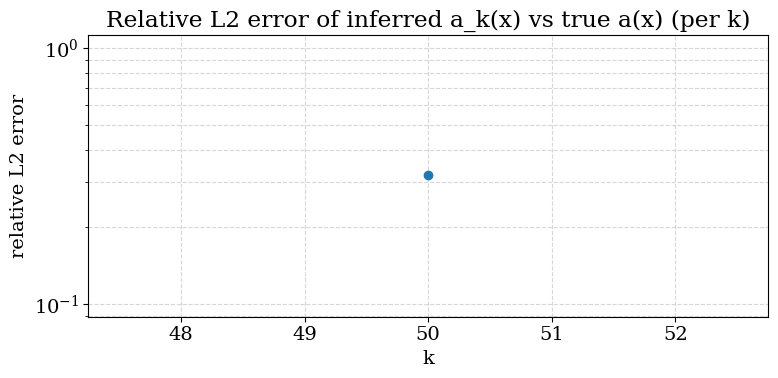

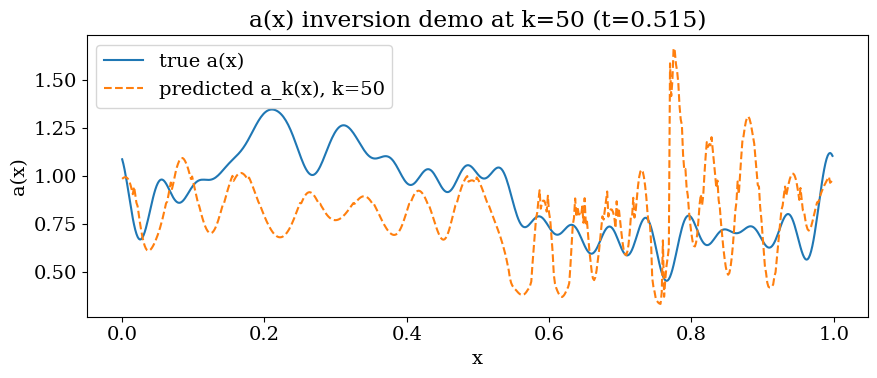

k_plot=50
rel_err=3.184e-01


In [43]:
k_solve = 50
a_init = 0.8 * np.ones_like(x_grid)

a_hat_k, fval, sec, ok, nit = invert_a_single_timestep_nonparametric_L2(
    k_solve=k_solve,
    x_grid=x_grid, L=L, t_uniform=t_uniform, Vr_u_hist=Vr_u_hist, eps=eps,
    a_init=a_init,
    a_bounds=(0.0, 3.0),
    lam_L2=1e-6,     # <-- tune this
    maxiter=25,
    ftol=1e-10,
    verbose=True
)

a_hat_hist, rel_err_hist = package_single_k_results_for_plots(
    k_solve=k_solve,
    a_hat_k=a_hat_k,
    x_grid=x_grid, L=L, t_uniform=t_uniform,
    true_a=a_adv  # or None
)

plot_single_k_diagnostics(
    k_plot=k_solve,
    x_grid=x_grid, t_uniform=t_uniform,
    a_hat_hist=a_hat_hist,
    rel_err_hist=rel_err_hist,
    true_a=a_adv,   # or None
    L=L
)


## First attempt: Assume we know the structure of a(x)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
# Invert a(x) per time step k by maximizing
#   || V_{k+1}^T T_k(a) V_k ||_F
# T_k(a) uses semi-Lagrangian departure points obtained by
# backward-Euler characteristic equation:
#  x_dep = x - dt_k * a(x_dep) * exp(-eps * t_{k+1})
#
# We parameterize a(x) by theta=[a_base, a_amp, mu, sigma]:
#   a(x;theta) = a_base + a_amp * periodic_gaussian(x; mu, sigma)
# ============================================================

# ----------------------------
# Periodized Gaussian + parameterized a(x)
# ----------------------------
def periodic_gaussian(x, mu, sigma, L):
    return (np.exp(-((x - mu) / sigma) ** 2)
          + np.exp(-((x - (mu - L)) / sigma) ** 2)
          + np.exp(-((x - (mu + L)) / sigma) ** 2))

def a_from_theta(x, theta, L):
    a_base, a_amp, mu, sigma = theta
    return a_base + a_amp * periodic_gaussian(x % L, mu, sigma, L)

# ----------------------------
# Periodic linear interpolation on uniform grid
# ----------------------------
def interp_periodic_1d(u, xq, L):
    u = np.asarray(u)
    xq = np.mod(np.asarray(xq), L)
    N = u.size
    dx = L / N
    i0 = np.floor(xq / dx).astype(int) % N
    frac = (xq - i0 * dx) / dx
    return (1 - frac) * u[i0] + frac * u[(i0 + 1) % N]

# ----------------------------
# Departure points: backward Euler in x, solved by fixed-point iteration
#   x_dep = x - dt * a(x_dep) * exp(-eps * t_arrival)
# ----------------------------
def departure_points_backward_euler(theta, x_grid, dt, L, t_arrival, eps,
                                    n_iter=20, tol=1e-12):
    x = np.asarray(x_grid)
    fac = np.exp(-eps * t_arrival)

    # initial guess: explicit Euler backtrace
    xdep = (x - dt * a_from_theta(x, theta, L) * fac) % L

    for _ in range(n_iter):
        xnew = (x - dt * a_from_theta(xdep, theta, L) * fac) % L
        if np.max(np.abs(xnew - xdep)) < tol:
            xdep = xnew
            break
        xdep = xnew

    return xdep

# ----------------------------
# Apply T_k(a) to each column of Vk
# ----------------------------
def apply_shift_to_basis(Vk, x_dep, L):
    Vk = np.asarray(Vk)
    N, r = Vk.shape
    S_Vk = np.empty_like(Vk)
    for j in range(r):
        S_Vk[:, j] = interp_periodic_1d(Vk[:, j], x_dep, L)
    return S_Vk

# ----------------------------
# Objective: minimize negative Fro^2 of projected operator
#   J(theta) = -|| V_{k+1}^T T_k(a(theta)) V_k ||_F^2
# ----------------------------
def objective_neg_fro2(theta, Vk, Vkp1, x_grid, dt, L, t_arrival, eps):
    x_dep = departure_points_backward_euler(theta, x_grid, dt, L, t_arrival, eps)
    S_Vk = apply_shift_to_basis(Vk, x_dep, L)
    Ared = Vkp1.T @ S_Vk
    return -np.linalg.norm(Ared, ord="fro")**2

# ----------------------------
# Per-k inversion wrapper
# ----------------------------
def invert_a_per_timestep(
    x_grid, L, t_uniform, Vr_u_hist, eps,
    theta_init,
    bounds,
    maxiter=60,
    ftol=1e-10,
    true_theta=None
):
    x_grid = np.asarray(x_grid)
    K = len(t_uniform)
    dt_k = float(t_uniform[1] - t_uniform[0])

    theta_hat_hist = np.zeros((K-1, 4), dtype=float)
    a_hat_hist = np.zeros((K-1, x_grid.size), dtype=float)
    rel_err_hist = np.full(K-1, np.nan, dtype=float)

    if true_theta is not None:
        a_true = a_from_theta(x_grid, true_theta, L)
        dx = L / x_grid.size
        denom = np.sqrt(np.sum(a_true**2) * dx) + 1e-14
    else:
        a_true = None
        denom = None

    theta_prev = np.array(theta_init, dtype=float)

    for k in range(K-1):
        Vk = Vr_u_hist[k]
        Vkp1 = Vr_u_hist[k+1]
        t_arrival = float(t_uniform[k+1])

        res = minimize(
            objective_neg_fro2,
            x0=theta_prev,
            args=(Vk, Vkp1, x_grid, dt_k, L, t_arrival, eps),
            method="L-BFGS-B",
            bounds=bounds,
            options={"maxiter": maxiter, "ftol": ftol}
        )

        theta_hat = res.x
        theta_hat_hist[k, :] = theta_hat

        a_hat = a_from_theta(x_grid, theta_hat, L)
        a_hat_hist[k, :] = a_hat

        if a_true is not None:
            dx = L / x_grid.size
            num = np.sqrt(np.sum((a_hat - a_true)**2) * dx)
            rel_err_hist[k] = num / denom

        # warm-start for next k
        theta_prev = theta_hat

    return theta_hat_hist, a_hat_hist, rel_err_hist


# ============================================================
# HOW TO USE IN YOUR NOTEBOOK (where Vr_u_hist already exists)
# ============================================================
#
# REQUIRED EXISTING VARIABLES:
#   x_grid, L, t_uniform, Vr_u_hist, eps
#
# Also define the true_theta that generated your data (for error + plotting).
# ============================================================

# Example (edit to your true a(x) parameters):
true_theta = np.array([0.55, 0.55, 0.60*L, 0.18*L], dtype=float)

# Initial guess:
theta0 = np.array([0.6, 0.4, 0.5*L, 0.15*L], dtype=float)

# Bounds (important to prevent nonsense values):
bounds = [
    (0.0, 2.5),        # a_base
    (0.0, 2.5),        # a_amp
    (0.0, L),          # mu
    (0.01*L, 0.5*L)    # sigma
]

theta_hat_hist, a_hat_hist, rel_err_hist = invert_a_per_timestep(
    x_grid=x_grid,
    L=L,
    t_uniform=t_uniform,
    Vr_u_hist=Vr_u_hist,
    eps=eps,
    theta_init=theta0,
    bounds=bounds,
    maxiter=60,
    ftol=1e-10,
    true_theta=true_theta
)

# ---- error vs k plot ----
plt.figure(figsize=(8,4))
plt.semilogy(rel_err_hist + 1e-18)
plt.title("Relative L2 error of inferred a(x) vs true a(x) (per k)")
plt.xlabel("k")
plt.ylabel("relative L2 error")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()

# ---- demo plot: choose k_plot (changeable) ----
k_plot = 0   # <--- YOU CAN CHANGE THIS
k_plot = int(np.clip(k_plot, 0, len(t_uniform)-2))

a_true = a_from_theta(x_grid, true_theta, L)
a_pred = a_hat_hist[k_plot]

plt.figure(figsize=(9,4))
plt.plot(x_grid, a_true, label="true a(x)")
plt.plot(x_grid, a_pred, "--", label=f"predicted a_k(x), k={k_plot}")
plt.title(f"a(x) inversion demo at k={k_plot} (t={t_uniform[k_plot+1]:.3f})")
plt.xlabel("x")
plt.ylabel("a(x)")
plt.legend()
plt.tight_layout()
plt.show()

print(f"k_plot={k_plot} | rel_err={rel_err_hist[k_plot]:.3e}")
print("true_theta   =", true_theta)
print("theta_hat[k] =", theta_hat_hist[k_plot])


In [ ]:
# ---- demo plot: choose k_plot (changeable) ----
k_plot = 400   # <--- YOU CAN CHANGE THIS
k_plot = int(np.clip(k_plot, 0, len(t_uniform)-2))

a_true = a_from_theta(x_grid, true_theta, L)
a_pred = a_hat_hist[k_plot]

plt.figure(figsize=(9,4))
plt.plot(x_grid, a_true, label="true a(x)")
plt.plot(x_grid, a_pred, "--", label=f"predicted a_k(x), k={k_plot}")
plt.title(f"a(x) inversion demo at k={k_plot} (t={t_uniform[k_plot+1]:.3f})")
plt.xlabel("x")
plt.ylabel("a(x)")
plt.legend()
plt.tight_layout()
plt.show()

print(f"k_plot={k_plot} | rel_err={rel_err_hist[k_plot]:.3e}")
print("true_theta   =", true_theta)
print("theta_hat[k] =", theta_hat_hist[k_plot])

## 2nd attemp: first attempt + regularization

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# ----------------------------
# Regularization terms
# ----------------------------
def smoothness_penalty(a_vec, dx):
    da = (np.roll(a_vec, -1) - a_vec) / dx
    return np.sum(da**2) * dx

def sigma_barrier(theta, sigma_ref, p=2):
    sigma = float(theta[3])
    return (sigma_ref / max(sigma, 1e-12))**p

# ----------------------------
# Regularized objective
# ----------------------------
def objective_reg(theta, Vk, Vkp1, x_grid, dt, L, t_arrival, eps,
                  lam_smooth, lam_sigma, sigma_ref, p_sigma,
                  a_from_theta, departure_points_backward_euler,
                  apply_shift_to_basis, dx):
    # fit term
    x_dep = departure_points_backward_euler(theta, x_grid, dt, L, t_arrival, eps)
    S_Vk = apply_shift_to_basis(Vk, x_dep, L)
    Ared = Vkp1.T @ S_Vk
    fit = -np.linalg.norm(Ared, ord="fro")**2

    # regularization
    a_vec = a_from_theta(x_grid, theta, L)
    reg_smooth = lam_smooth * smoothness_penalty(a_vec, dx)
    reg_sigma  = lam_sigma  * sigma_barrier(theta, sigma_ref=sigma_ref, p=p_sigma)

    return fit + reg_smooth + reg_sigma

# ----------------------------
# Per-k inversion loop (regularized)
# ----------------------------
def invert_a_per_timestep_regularized(
    x_grid, L, t_uniform, Vr_u_hist, eps,
    theta_init, bounds,
    lam_smooth=5e-2,
    lam_sigma=1e-1,
    sigma_ref=0.18,
    p_sigma=2,
    maxiter=60,
    ftol=1e-10,
    true_theta=None,
    a_from_theta=None,
    departure_points_backward_euler=None,
    apply_shift_to_basis=None
):
    x_grid = np.asarray(x_grid)
    K = len(t_uniform)
    dt_k = float(t_uniform[1] - t_uniform[0])
    dx = L / x_grid.size

    theta_hat_hist = np.zeros((K-1, 4), dtype=float)
    a_hat_hist = np.zeros((K-1, x_grid.size), dtype=float)
    rel_err_hist = np.full(K-1, np.nan, dtype=float)

    if true_theta is not None:
        a_true = a_from_theta(x_grid, true_theta, L)
        denom = np.sqrt(np.sum(a_true**2) * dx) + 1e-14
    else:
        a_true = None
        denom = None

    theta_prev = np.array(theta_init, dtype=float)

    for k in range(K-1):
        Vk = Vr_u_hist[k]
        Vkp1 = Vr_u_hist[k+1]
        t_arrival = float(t_uniform[k+1])

        res = minimize(
            objective_reg,
            x0=theta_prev,
            args=(Vk, Vkp1, x_grid, dt_k, L, t_arrival, eps,
                  lam_smooth, lam_sigma, sigma_ref, p_sigma,
                  a_from_theta, departure_points_backward_euler,
                  apply_shift_to_basis, dx),
            method="L-BFGS-B",
            bounds=bounds,
            options={"maxiter": maxiter, "ftol": ftol}
        )

        theta_hat = res.x
        theta_hat_hist[k, :] = theta_hat

        a_hat = a_from_theta(x_grid, theta_hat, L)
        a_hat_hist[k, :] = a_hat

        if a_true is not None:
            num = np.sqrt(np.sum((a_hat - a_true)**2) * dx)
            rel_err_hist[k] = num / denom

        theta_prev = theta_hat  # warm start

    return theta_hat_hist, a_hat_hist, rel_err_hist


In [ ]:
# ---- demo plot: choose k_plot (changeable) ----
k_plot = 100  # <--- YOU CAN CHANGE THIS
k_plot = int(np.clip(k_plot, 0, len(t_uniform)-2))

a_true = a_from_theta(x_grid, true_theta, L)
a_pred = a_hat_hist[k_plot]

plt.figure(figsize=(9,4))
plt.plot(x_grid, a_true, label="true a(x)")
plt.plot(x_grid, a_pred, "--", label=f"predicted a_k(x), k={k_plot}")
plt.title(f"Regularized a(x) inversion at k={k_plot} (t={t_uniform[k_plot+1]:.3f})")
plt.xlabel("x")
plt.ylabel("a(x)")
plt.legend()
plt.tight_layout()
plt.show()


## 3rd Attempt: Changing objective function to data misfit


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# ----------------------------
# Parameterization a(x;theta) = base + amp * periodic_gaussian(x;mu,sigma)
# ----------------------------
def periodic_gaussian(x, mu, sigma, L):
    return (np.exp(-((x - mu)/sigma)**2)
          + np.exp(-((x - (mu - L))/sigma)**2)
          + np.exp(-((x - (mu + L))/sigma)**2))

def a_from_theta(x, theta, L):
    a_base, a_amp, mu, sigma = theta
    return a_base + a_amp * periodic_gaussian(x % L, mu, sigma, L)

# ----------------------------
# Periodic linear interpolation on uniform grid
# ----------------------------
def interp_periodic_1d(u, xq, L):
    u = np.asarray(u)
    xq = np.mod(np.asarray(xq), L)
    N = u.size
    dx = L / N
    i0 = np.floor(xq / dx).astype(int) % N
    frac = (xq - i0*dx) / dx
    return (1 - frac) * u[i0] + frac * u[(i0 + 1) % N]

# ----------------------------
# FIX 3: correct departure points via backward-Euler in x (arrival -> departure)
# x_dep = x_arr - dt * a(x_dep) * exp(-eps * t_arrival)
# ----------------------------
def departure_points_backward_euler(theta, x_arr, dt, L, t_arrival, eps,
                                    n_iter=25, tol=1e-12):
    x_arr = np.asarray(x_arr)
    fac = np.exp(-eps * t_arrival)

    # initial guess: explicit backtrace
    xdep = (x_arr - dt * a_from_theta(x_arr, theta, L) * fac) % L

    for _ in range(n_iter):
        xnew = (x_arr - dt * a_from_theta(xdep, theta, L) * fac) % L
        if np.max(np.abs(xnew - xdep)) < tol:
            xdep = xnew
            break
        xdep = xnew
    return xdep

# ----------------------------
# Apply T_k(a) to a snapshot matrix U_k (N,M): columnwise interpolation
# ----------------------------
def apply_shift_to_snapshots(Uk, x_dep, L):
    """
    Apply T_k(a) to snapshot matrix Uk using periodic interpolation.

    Accepts Uk shaped (N,M) or (M,N).
    Returns same shape orientation as input.
    """
    Uk = np.asarray(Uk)
    x_dep = np.asarray(x_dep)

    if Uk.ndim != 2:
        raise ValueError(f"Uk must be 2D, got shape {Uk.shape}")

    # Case 1: Uk is (N,M)
    if Uk.shape[0] == x_dep.size:
        N, M = Uk.shape
        TUk = np.empty_like(Uk)
        for m in range(M):
            TUk[:, m] = interp_periodic_1d(Uk[:, m], x_dep, L)
        return TUk

    # Case 2: Uk is (M,N) -> shift each row and return (M,N)
    if Uk.shape[1] == x_dep.size:
        M, N = Uk.shape
        TUk = np.empty_like(Uk)
        for m in range(M):
            TUk[m, :] = interp_periodic_1d(Uk[m, :], x_dep, L)
        return TUk

    raise ValueError(
        f"Shape mismatch: Uk shape {Uk.shape}, but x_dep has length {x_dep.size}. "
        "Expected Uk to be (N,M) or (M,N) with N=len(x_dep)."
    )


# ----------------------------
# Regularization
# ----------------------------
def smoothness_penalty(a_vec, dx):
    da = (np.roll(a_vec, -1) - a_vec) / dx
    return np.sum(da**2) * dx

def sigma_barrier(theta, sigma_ref, p=2):
    sigma = float(theta[3])
    return (sigma_ref / max(sigma, 1e-12))**p

# ----------------------------
# FIX 1: data misfit objective per k
# J_k(theta) = ||U_{k+1} - T_k(a(theta)) U_k||_F^2 + regs
# ----------------------------
def objective_data_misfit_reg(theta, Uk, Ukp1, x_grid, dt, L, t_arrival, eps,
                             lam_smooth, lam_sigma, sigma_ref, p_sigma):
    dx = L / x_grid.size

    # build T_k(a(theta)) via departure points
    x_dep = departure_points_backward_euler(theta, x_grid, dt, L, t_arrival, eps)
    TUk = apply_shift_to_snapshots(Uk, x_dep, L)

    # data misfit
    misfit = np.linalg.norm(Ukp1 - TUk, ord="fro")**2

    # regularization
    a_vec = a_from_theta(x_grid, theta, L)
    reg_s = lam_smooth * smoothness_penalty(a_vec, dx)
    reg_b = lam_sigma  * sigma_barrier(theta, sigma_ref=sigma_ref, p=p_sigma)

    return misfit + reg_s + reg_b

# ----------------------------
# Invert per k and save a_hat_k(x) + error per step
# ----------------------------
def invert_a_per_k_data_misfit(
    u_hist_tensor, x_grid, L, t_uniform, eps,
    theta_init, bounds,
    lam_smooth=1e-2,
    lam_sigma=1e-1,
    sigma_ref=0.18,
    p_sigma=2,
    maxiter=80,
    ftol=1e-10,
    a_true=None
):
    # u_hist_tensor can be (N,M,K) or (M,N,K)
    Ngrid = x_grid.size
    K = u_hist_tensor.shape[2]
    dt = float(t_uniform[1] - t_uniform[0])
    dx = L / Ngrid

    theta_hat_hist = np.zeros((K-1, 4))
    a_hat_hist = np.zeros((K-1, N))
    rel_err_hist = np.full(K-1, np.nan)

    if a_true is not None:
        denom = np.sqrt(np.sum(a_true**2) * dx) + 1e-14

    theta_prev = np.array(theta_init, dtype=float)

    for k in range(K-1):
        Uk   = u_hist_tensor[:, :, k]
        Ukp1 = u_hist_tensor[:, :, k+1]
        t_arrival = float(t_uniform[k+1])

        res = minimize(
            objective_data_misfit_reg,
            x0=theta_prev,
            args=(Uk, Ukp1, x_grid, dt, L, t_arrival, eps,
                  lam_smooth, lam_sigma, sigma_ref, p_sigma),
            method="L-BFGS-B",
            bounds=bounds,
            options={"maxiter": maxiter, "ftol": ftol}
        )

        theta_hat = res.x
        theta_hat_hist[k, :] = theta_hat
        a_hat = a_from_theta(x_grid, theta_hat, L)
        a_hat_hist[k, :] = a_hat

        if a_true is not None:
            num = np.sqrt(np.sum((a_hat - a_true)**2) * dx)
            rel_err_hist[k] = num / denom

        # warm start
        theta_prev = theta_hat

    return theta_hat_hist, a_hat_hist, rel_err_hist

# ============================================================
# USAGE (you already have u_hist_tensor and true a(x) from the forward run)
# ============================================================

# Example true a(x) (replace with your actual known a_adv if you have it)
# a_true = a_adv.copy()

# Initial guess + bounds (same style as before)
theta0 = np.array([0.6, 0.4, 0.5*L, 0.15*L], dtype=float)
bounds = [(0.0, 2.5), (0.0, 2.5), (0.0, L), (0.01*L, 0.5*L)]

theta_hat_hist, a_hat_hist, rel_err_hist = invert_a_per_k_data_misfit(
    u_hist_tensor=u_hist_tensor,
    x_grid=x_grid,
    L=L,
    t_uniform=t_uniform,
    eps=eps,
    theta_init=theta0,
    bounds=bounds,
    lam_smooth=5e-2,
    lam_sigma=1e-1,
    sigma_ref=0.18*L,
    p_sigma=2,
    maxiter=80,
    ftol=1e-10,
    a_true=a_true  # pass None if you don't want error
)

# --- error per k ---
plt.figure(figsize=(8,4))
plt.semilogy(rel_err_hist + 1e-18)
plt.title("Per-k inversion error (data misfit + regularization)")
plt.xlabel("k")
plt.ylabel("relative L2 error in a(x)")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()

# --- demo plot for selectable k_plot ---
k_plot = 50  # <--- change this freely
k_plot = int(np.clip(k_plot, 0, len(t_uniform)-2))

plt.figure(figsize=(9,4))
plt.plot(x_grid, a_true, label="true a(x)")
plt.plot(x_grid, a_hat_hist[k_plot], "--", label=f"predicted a_k(x), k={k_plot}")
plt.title(f"a(x) inversion at k={k_plot} (t={t_uniform[k_plot+1]:.3f})")
plt.xlabel("x")
plt.ylabel("a(x)")
plt.legend()
plt.tight_layout()
plt.show()

print(f"k_plot={k_plot} | rel_err={rel_err_hist[k_plot]:.3e}")
print("theta_hat[k] =", theta_hat_hist[k_plot])


# 4th attempt: keep objective and changes of 3rd, but now we assume no structure for a(x)

### This slow, but it works. So we will be using it for the the next cases.

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# ------------------------------------------------------------
# Periodic linear interpolation on uniform grid [0,L)
# ------------------------------------------------------------
def interp_periodic_on_grid(values_on_grid, xq, L):
    """
    values_on_grid: (N,)
    xq: array-like points in [0,L) (will be modded)
    """
    v = np.asarray(values_on_grid)
    xq = np.mod(np.asarray(xq), L)
    N = v.size
    dx = L / N
    i0 = np.floor(xq / dx).astype(int) % N
    frac = (xq - i0*dx) / dx
    return (1 - frac) * v[i0] + frac * v[(i0 + 1) % N]

# ------------------------------------------------------------
# Fix 3: departure points for general a(x) stored on grid
# Backward-Euler in space: x_dep = x_arr - dt * a(x_dep) * exp(-eps*t_arr)
# ------------------------------------------------------------
def departure_points_BE_from_avec(a_vec, x_arr, dt, L, t_arrival, eps,
                                 n_iter=30, tol=1e-12):
    x_arr = np.asarray(x_arr)
    fac = np.exp(-eps * t_arrival)

    # initial guess: explicit backtrace using a(x_arr)
    a_at_x = interp_periodic_on_grid(a_vec, x_arr, L)
    xdep = (x_arr - dt * a_at_x * fac) % L

    for _ in range(n_iter):
        a_at_xdep = interp_periodic_on_grid(a_vec, xdep, L)
        xnew = (x_arr - dt * a_at_xdep * fac) % L
        if np.max(np.abs(xnew - xdep)) < tol:
            xdep = xnew
            break
        xdep = xnew
    return xdep

# ------------------------------------------------------------
# Apply T_k(a) to snapshot matrix Uk (supports (N,M) or (M,N))
# ------------------------------------------------------------
def apply_shift_to_snapshots(Uk, x_dep, L):
    Uk = np.asarray(Uk)
    x_dep = np.asarray(x_dep)

    # (N,M)
    if Uk.shape[0] == x_dep.size:
        N, M = Uk.shape
        TUk = np.empty_like(Uk)
        for m in range(M):
            TUk[:, m] = interp_periodic_on_grid(Uk[:, m], x_dep, L)
        return TUk

    # (M,N)
    if Uk.shape[1] == x_dep.size:
        M, N = Uk.shape
        TUk = np.empty_like(Uk)
        for m in range(M):
            TUk[m, :] = interp_periodic_on_grid(Uk[m, :], x_dep, L)
        return TUk

    raise ValueError(f"Uk shape {Uk.shape} incompatible with x_dep length {x_dep.size}")

# ------------------------------------------------------------
# H^1 periodic smoothness penalty: ||Da||_2^2
# ------------------------------------------------------------
def H1_penalty(a_vec, dx):
    da = (np.roll(a_vec, -1) - a_vec) / dx
    return np.sum(da**2) * dx

# ------------------------------------------------------------
# Per-k objective: data misfit + lambda * H1
# ------------------------------------------------------------
def objective_avec(a_vec, Uk, Ukp1, x_grid, dt, L, t_arrival, eps, lam_H1):
    dx = L / x_grid.size

    x_dep = departure_points_BE_from_avec(a_vec, x_grid, dt, L, t_arrival, eps)
    TUk = apply_shift_to_snapshots(Uk, x_dep, L)

    misfit = np.linalg.norm(Ukp1 - TUk, ord="fro")**2
    reg = lam_H1 * H1_penalty(a_vec, dx)
    return misfit + reg

# ------------------------------------------------------------
# Invert for a_k (grid vector) for each k, save a_hat and errors
# ------------------------------------------------------------
def invert_a_per_k_nonparametric(
    u_hist_tensor, x_grid, L, t_uniform, eps,
    a_init, a_bounds=(0.0, 3.0),
    lam_H1=1e-2,
    maxiter=60,
    ftol=1e-10,
    a_true=a_adv
):
    """
    u_hist_tensor: snapshots, either (N,M,K) or (M,N,K)
    a_init: (N,) initial guess for a
    a_bounds: tuple (amin, amax) applied to all grid entries
    """
    x_grid = np.asarray(x_grid)
    Ngrid = x_grid.size
    K = u_hist_tensor.shape[2]
    dt = float(t_uniform[1] - t_uniform[0])
    dx = L / Ngrid

    a_hat_hist = np.zeros((K-1, Ngrid), dtype=float)
    rel_err_hist = np.full(K-1, np.nan, dtype=float)

    bounds = [a_bounds] * Ngrid

    if a_true is not None:
        denom = np.sqrt(np.sum(a_true**2) * dx) + 1e-14

    a_prev = np.asarray(a_init, dtype=float).copy()

    for k in range(K-1):
        Uk   = u_hist_tensor[:, :, k]
        Ukp1 = u_hist_tensor[:, :, k+1]
        t_arrival = float(t_uniform[k+1])

        res = minimize(
            objective_avec,
            x0=a_prev,
            args=(Uk, Ukp1, x_grid, dt, L, t_arrival, eps, lam_H1),
            method="L-BFGS-B",
            bounds=bounds,
            jac="2-point",  # finite-difference gradient (expensive but structure-free)
            options={"maxiter": maxiter, "ftol": ftol}
        )

        a_hat = res.x
        a_hat_hist[k, :] = a_hat

        if a_true is not None:
            num = np.sqrt(np.sum((a_hat - a_true)**2) * dx)
            rel_err_hist[k] = num / denom

        a_prev = a_hat  # warm-start

        if (k % 20) == 0 or k == K-2:
            msg = f"k={k:4d}/{K-2} | J={res.fun:.3e}"
            if a_true is not None:
                msg += f" | rel_err={rel_err_hist[k]:.3e}"
            print(msg)

    return a_hat_hist, rel_err_hist

### single timestep

[single-k] k=50 | success=False | iters=10 | fval=3.693e-02 | time=30.32s


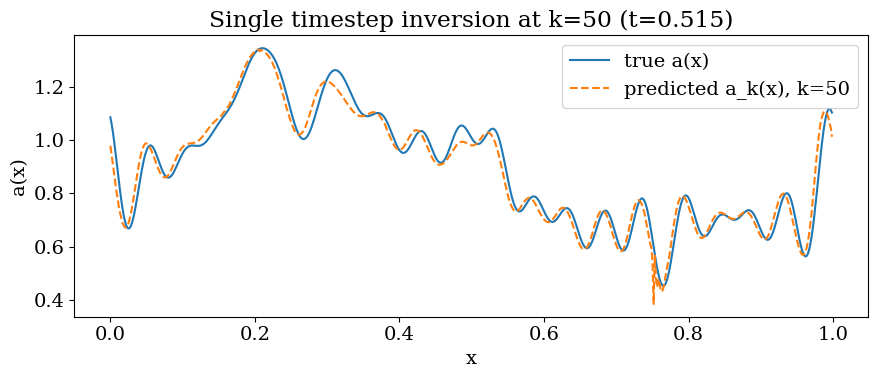

relative L2 error: 0.04498358623970944


In [46]:
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

def invert_a_single_k(
    k_solve,
    u_hist_tensor, x_grid, L, t_uniform, eps,
    a_init,
    a_bounds=(0.0, 3.0),
    lam_H1=1e-2,
    maxiter=40,
    ftol=1e-10,
    verbose=True
):
    """
    Solve the nonparametric inverse problem for ONE timestep k_solve:
        min_a ||U_{k+1} - T_k(a) U_k||_F^2 + lam_H1 * ||Da||_2^2

    Returns:
        a_hat (N,), fval, elapsed_sec, success_flag
    """
    x_grid = np.asarray(x_grid)
    Ngrid = x_grid.size
    K = u_hist_tensor.shape[2]
    if not (0 <= k_solve <= K-2):
        raise ValueError(f"k_solve must be in [0, {K-2}], got {k_solve}")

    dt = float(t_uniform[1] - t_uniform[0])
    bounds = [a_bounds] * Ngrid

    Uk   = u_hist_tensor[:, :, k_solve]
    Ukp1 = u_hist_tensor[:, :, k_solve + 1]
    t_arrival = float(t_uniform[k_solve + 1])

    t0 = time.perf_counter()
    res = minimize(
        objective_avec,
        x0=np.asarray(a_init, dtype=float),
        args=(Uk, Ukp1, x_grid, dt, L, t_arrival, eps, lam_H1),
        method="L-BFGS-B",
        bounds=bounds,
        jac="2-point",  # finite difference gradient
        options={"maxiter": maxiter, "ftol": ftol}
    )
    t1 = time.perf_counter()

    if verbose:
        print(f"[single-k] k={k_solve} | success={res.success} | "
              f"iters={res.nit} | fval={res.fun:.3e} | time={t1-t0:.2f}s")

    return res.x, float(res.fun), (t1 - t0), bool(res.success)


# ============================
# USAGE
# ============================

# Choose ONE timestep to invert
k_solve = 50   # <--- change this

# Initial guess for a(x)
a_init = 0.8 * np.ones_like(x_grid)

a_hat_k, fval, sec, ok = invert_a_single_k(
    k_solve=k_solve,
    u_hist_tensor=u_hist_tensor,
    x_grid=x_grid,
    L=L,
    t_uniform=t_uniform,
    eps=eps,
    a_init=a_init,
    a_bounds=(0.0, 3.0),
    lam_H1=5e-6,
    maxiter=25,      # keep small for a quick test
    ftol=1e-10,
    verbose=True
)

# Plot predicted vs true if you have a_true
plt.figure(figsize=(9,4))
plt.plot(x_grid, a_adv, label="true a(x)")
plt.plot(x_grid, a_hat_k, "--", label=f"predicted a_k(x), k={k_solve}")
plt.title(f"Single timestep inversion at k={k_solve} (t={t_uniform[k_solve+1]:.3f})")
plt.xlabel("x")
plt.ylabel("a(x)")
plt.legend()
plt.tight_layout()
plt.show()

# Optional: print relative L2 error
dx = L / x_grid.size
den = np.sqrt(np.sum(a_adv**2) * dx) + 1e-14
num = np.sqrt(np.sum((a_hat_k - a_adv)**2) * dx)
print("relative L2 error:", num / den)


In [47]:
dt = float(t_uniform[1] - t_uniform[0])

Uk   = u_hist_tensor[:, :, k_solve]
Ukp1 = u_hist_tensor[:, :, k_solve + 1]

w_hat_vec = a_adv

# departure points from w only
x_dep = departure_points_BE_from_wvec(w_hat_vec, x_grid, dt, L)

# apply T_k(w) to Uk
TUk = apply_shift_to_snapshots(Uk, x_dep, L)

# --- Data misfit ---
misfit_F = np.linalg.norm(Ukp1 - TUk, ord="fro")
misfit_F2 = misfit_F**2

print(f"|| U_{k_solve+1} - T_k(w_hat) U_{k_solve} ||_F  = {misfit_F:.6e}")
print(f"|| U_{k_solve+1} - T_k(w_hat) U_{k_solve} ||_F^2 = {misfit_F2:.6e}")


# compute || Ukp1^T (TUk) ||_F
val = frob_cross_gram(Ukp1, TUk)
print(f"|| U_{k_solve+1}^T (T_k(w_hat) U_{k_solve}) ||_F = {val:.6e}")

NameError: name 'departure_points_BE_from_wvec' is not defined

In [48]:
for lam in [1e-1, 5e-2, 1e-2, 5e-3, 1e-3]:
    a_hat_k, fval, sec, ok = invert_a_single_k(
        k_solve=k_solve,
        u_hist_tensor=u_hist_tensor,
        x_grid=x_grid, L=L, t_uniform=t_uniform, eps=eps,
        a_init=a_init,
        a_bounds=(0.0, 3.0),
        lam_H1=lam,
        maxiter=30,
        ftol=1e-10,
        verbose=True
    )
    dx = L / x_grid.size
    rel = np.sqrt(np.sum((a_hat_k-a_true)**2)*dx) / (np.sqrt(np.sum(a_true**2)*dx)+1e-14)
    print("lam_H1 =", lam, "rel_err =", rel)


KeyboardInterrupt: 

### Parallel

In [ ]:
import time
import numpy as np
from joblib import Parallel, delayed, dump, load
from scipy.optimize import minimize

# ---- assumes you already defined these from earlier code ----
# objective_avec(a_vec, Uk, Ukp1, x_grid, dt, L, t_arrival, eps, lam_H1)
# (and inside objective_avec you call departure_points_BE_from_avec etc.)

def solve_one_k_timed(
    k, u_hist_mmap, x_grid, L, t_uniform, eps,
    a_init, a_bounds, lam_H1, maxiter, ftol,
    a_true=None
):
    """
    Solve the inverse problem for a single k.
    Returns:
        (k, a_hat_k, rel_err_k, seconds_for_this_k, success_flag, final_obj)
    """
    t0 = time.perf_counter()

    x_grid = np.asarray(x_grid)
    Ngrid = x_grid.size
    dt = float(t_uniform[1] - t_uniform[0])
    dx = L / Ngrid

    Uk   = u_hist_mmap[:, :, k]
    Ukp1 = u_hist_mmap[:, :, k+1]
    t_arrival = float(t_uniform[k+1])

    bounds = [a_bounds] * Ngrid

    res = minimize(
        objective_avec,
        x0=np.asarray(a_init, dtype=float),
        args=(Uk, Ukp1, x_grid, dt, L, t_arrival, eps, lam_H1),
        method="L-BFGS-B",
        bounds=bounds,
        jac="2-point",  # finite-difference gradient
        options={"maxiter": maxiter, "ftol": ftol}
    )

    a_hat_k = res.x

    if a_true is not None:
        denom = np.sqrt(np.sum(a_true**2) * dx) + 1e-14
        num = np.sqrt(np.sum((a_hat_k - a_true)**2) * dx)
        rel_err_k = num / denom
    else:
        rel_err_k = np.nan

    t1 = time.perf_counter()
    return k, a_hat_k, rel_err_k, (t1 - t0), bool(res.success), float(res.fun)


def invert_a_per_k_nonparametric_parallel_timed(
    u_hist_tensor, x_grid, L, t_uniform, eps,
    a_init, a_bounds=(0.0, 3.0),
    lam_H1=1e-2,
    maxiter=60,
    ftol=1e-10,
    a_true=None,
    n_jobs=-1,
    backend="loky",          # "loky" (processes) or "threading"
    verbose=10,
    mmap_folder="/tmp",
    mmap_name="u_hist_tensor_mmap.pkl"
):
    """
    Parallel per-k inversion with progress + timing summary.
    Returns:
        a_hat_hist: (K-1, N)
        rel_err_hist: (K-1,)
        info: dict with timing and success stats
    """
    # ---- Memmap snapshots to avoid copying to workers ----
    mmap_path = f"{mmap_folder.rstrip('/')}/{mmap_name}"
    dump(u_hist_tensor, mmap_path)
    u_hist_mmap = load(mmap_path, mmap_mode="r")

    Ngrid = x_grid.size
    K = u_hist_mmap.shape[2]
    if K != len(t_uniform):
        raise ValueError(f"Mismatch: u_hist_tensor has K={K}, t_uniform has {len(t_uniform)}")

    # ---- Run parallel and time total wall time ----
    wall0 = time.perf_counter()

    results = Parallel(n_jobs=n_jobs, backend=backend, verbose=verbose)(
        delayed(solve_one_k_timed)(
            k, u_hist_mmap, x_grid, L, t_uniform, eps,
            a_init, a_bounds, lam_H1, maxiter, ftol,
            a_true
        )
        for k in range(K - 1)
    )

    wall1 = time.perf_counter()
    wall_time = wall1 - wall0

    # ---- Collect results ----
    a_hat_hist = np.zeros((K-1, Ngrid), dtype=float)
    rel_err_hist = np.full(K-1, np.nan, dtype=float)

    per_k_sec = np.zeros(K-1, dtype=float)
    success = np.zeros(K-1, dtype=bool)
    final_obj = np.zeros(K-1, dtype=float)

    for (k, a_hat_k, rel_err_k, sec_k, ok, fval) in results:
        a_hat_hist[k, :] = a_hat_k
        rel_err_hist[k] = rel_err_k
        per_k_sec[k] = sec_k
        success[k] = ok
        final_obj[k] = fval

    # ---- Timing / progress summary ----
    info = {
        "wall_time_sec": wall_time,
        "per_k_sec_min": float(np.min(per_k_sec)),
        "per_k_sec_med": float(np.median(per_k_sec)),
        "per_k_sec_max": float(np.max(per_k_sec)),
        "avg_sec_per_k": float(np.mean(per_k_sec)),
        "n_steps": int(K-1),
        "n_success": int(np.sum(success)),
        "n_fail": int(np.sum(~success)),
    }

    print("\n========== Parallel inversion summary ==========")
    print(f"Total k steps          : {info['n_steps']}")
    print(f"Success / Fail         : {info['n_success']} / {info['n_fail']}")
    print(f"Total wall time (sec)  : {info['wall_time_sec']:.2f}")
    print(f"Avg sec per k          : {info['avg_sec_per_k']:.3f}")
    print(f"Per-k sec (min/med/max): "
          f"{info['per_k_sec_min']:.3f} / {info['per_k_sec_med']:.3f} / {info['per_k_sec_max']:.3f}")
    print("==============================================\n")

    return a_hat_hist, rel_err_hist, info


In [ ]:
a_init = 0.8 * np.ones_like(x_grid)

a_hat_hist, rel_err_hist, info = invert_a_per_k_nonparametric_parallel_timed(
    u_hist_tensor=u_hist_tensor,
    x_grid=x_grid,
    L=L,
    t_uniform=t_uniform,
    eps=eps,
    a_init=a_init,
    a_bounds=(0.0, 3.0),
    lam_H1=5e-2,
    maxiter=40,
    ftol=1e-10,
    a_true=a_true,     # or None
    n_jobs=-1,
    backend="loky",
    verbose=10         # <-- this is your live "done X tasks" progress
)


### Not parallel

In [ ]:
# ============================================================
# USAGE
# ============================================================
# You already have:
#   u_hist_tensor, x_grid, L, t_uniform, eps, and a_true (optional)
#
# Provide an initial guess a_init. Common choice: constant or smoothed estimate.
# ============================================================

# Example initial guess: constant field
a_init = 0.8 * np.ones_like(x_grid)

# Run inversion
a_hat_hist, rel_err_hist = invert_a_per_k_nonparametric(
    u_hist_tensor=u_hist_tensor,
    x_grid=x_grid,
    L=L,
    t_uniform=t_uniform,
    eps=eps,
    a_init=a_init,
    a_bounds=(0.0, 3.0),
    lam_H1=5e-2,      # tune
    maxiter=40,       # tune (increase for better convergence)
    ftol=1e-10,
    a_true=a_true     # or None if you don't want error
)

# Error plot
plt.figure(figsize=(8,4))
plt.semilogy(rel_err_hist + 1e-18)
plt.title("Per-k nonparametric inversion: relative L2 error in a(x)")
plt.xlabel("k")
plt.ylabel("relative L2 error")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()

# Demo plot at changeable k_plot
k_plot = 50  # <--- change this
k_plot = int(np.clip(k_plot, 0, len(t_uniform)-2))

plt.figure(figsize=(9,4))
plt.plot(x_grid, a_true, label="true a(x)")
plt.plot(x_grid, a_hat_hist[k_plot], "--", label=f"predicted a_k(x), k={k_plot}")
plt.title(f"Nonparametric a(x) inversion at k={k_plot} (t={t_uniform[k_plot+1]:.3f})")
plt.xlabel("x")
plt.ylabel("a(x)")
plt.legend()
plt.tight_layout()
plt.show()


# Proportional split

[single-k] k=50 | lam_hat=0.663763 | J=8.028e-02


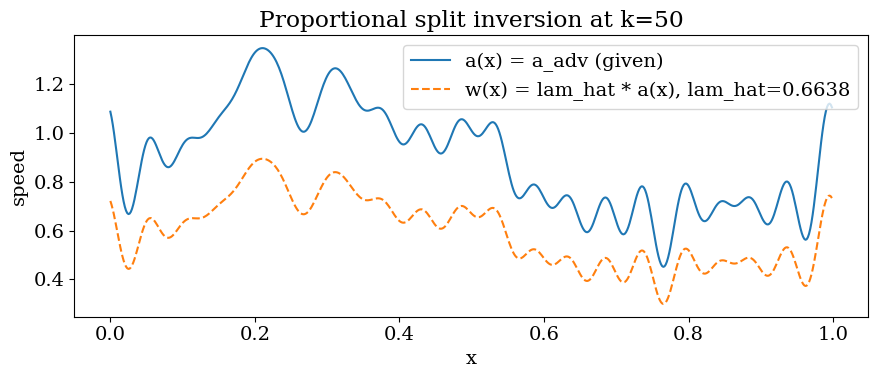

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

# ============================================================
# Assumptions (as you requested)
# 1) You already have:
#    - x_grid  (N,)
#    - L
#    - t_uniform (K,)
#    - u_hist_tensor: snapshots, either (N,M,K) or (M,N,K)
#    - a_adv  (N,)  <-- precomputed true advection speed a(x)
# 2) We use proportional split:
#       w(x) = lam * a(x),   v(x) = (1-lam) * a(x)
# 3) Semi-Lagrangian interpolation depends ONLY on w (i.e., lam*a).
# 4) We keep the objective structure: data misfit + H1 regularization (on w).
# ============================================================


# ------------------------------------------------------------
# Periodic linear interpolation on uniform grid [0,L)
# ------------------------------------------------------------
def interp_periodic_on_grid(values_on_grid, xq, L):
    v = np.asarray(values_on_grid)
    xq = np.mod(np.asarray(xq), L)
    N = v.size
    dx = L / N
    i0 = np.floor(xq / dx).astype(int) % N
    frac = (xq - i0 * dx) / dx
    return (1 - frac) * v[i0] + frac * v[(i0 + 1) % N]


# ------------------------------------------------------------
# Departure points driven by w(x) only (proportional split)
# Backward-Euler in space: x_dep = x_arr - dt * w(x_dep)
# ------------------------------------------------------------
def departure_points_BE_from_wvec(w_vec, x_arr, dt, L, n_iter=40, tol=1e-12):
    x_arr = np.asarray(x_arr)

    # initial guess: explicit backtrace
    w_at_x = interp_periodic_on_grid(w_vec, x_arr, L)
    xdep = (x_arr - dt * w_at_x) % L

    for _ in range(n_iter):
        w_at_xdep = interp_periodic_on_grid(w_vec, xdep, L)
        xnew = (x_arr - dt * w_at_xdep) % L
        if np.max(np.abs(xnew - xdep)) < tol:
            xdep = xnew
            break
        xdep = xnew
    return xdep


# ------------------------------------------------------------
# Apply shift T(w) to snapshot matrix Uk (supports (N,M) or (M,N))
# Returns same orientation as input Uk
# ------------------------------------------------------------
def apply_shift_to_snapshots(Uk, x_dep, L):
    Uk = np.asarray(Uk)
    x_dep = np.asarray(x_dep)

    # (N,M)
    if Uk.shape[0] == x_dep.size:
        N, M = Uk.shape
        TUk = np.empty_like(Uk)
        for m in range(M):
            TUk[:, m] = interp_periodic_on_grid(Uk[:, m], x_dep, L)
        return TUk

    # (M,N)
    if Uk.shape[1] == x_dep.size:
        M, N = Uk.shape
        TUk = np.empty_like(Uk)
        for m in range(M):
            TUk[m, :] = interp_periodic_on_grid(Uk[m, :], x_dep, L)
        return TUk

    raise ValueError(f"Uk shape {Uk.shape} incompatible with x_dep length {x_dep.size}")


# ------------------------------------------------------------
# First-order periodic upwind derivative (vectorized)
# dudx depends on a "direction" speed s(x): if s>=0 use backward diff else forward diff
# Works for a single field u (N,)
# ------------------------------------------------------------
def dudx_upwind1(u, s_vec, dx):
    u = np.asarray(u)
    s_vec = np.asarray(s_vec)

    u_im1 = np.roll(u,  1)
    u_ip1 = np.roll(u, -1)

    du_back = (u - u_im1) / dx
    du_forw = (u_ip1 - u) / dx

    return np.where(s_vec >= 0.0, du_back, du_forw)


# ------------------------------------------------------------
# H^1 periodic smoothness penalty: ||Dw||_2^2
# ------------------------------------------------------------
def H1_penalty(vec, dx):
    d = (np.roll(vec, -1) - vec) / dx
    return np.sum(d**2) * dx


# ------------------------------------------------------------
# Forward one-step predictor using proportional split:
#   u_t + (w+v) u_x = 0
# Rewrite: D_w u / Dt = - v u_x
#
# Discretization (first-order):
#   x_dep from w only (semi-Lagrangian)
#   u_{k+1}(x_i) ≈ u_k(x_dep) - dt * v(x_dep) * (u_x)_k(x_dep)
#
# where (u_x)_k is computed by upwind using w (direction) on the grid,
# then interpolated to x_dep.
# ------------------------------------------------------------
def predict_Ukp1_from_lambda(Uk, x_grid, L, dt, a_adv, lam):
    x_grid = np.asarray(x_grid)
    N = x_grid.size
    dx = L / N

    a_adv = np.asarray(a_adv)
    w_vec = lam * a_adv
    v_vec = (1.0 - lam) * a_adv

    # departure points depend only on w
    x_dep = departure_points_BE_from_wvec(w_vec, x_grid, dt, L)

    # transport part: u_k(x_dep)
    TUk = apply_shift_to_snapshots(Uk, x_dep, L)

    # compute u_x on the Eulerian grid (per snapshot), then shift it to x_dep too
    # IMPORTANT: derivative direction uses w_vec (the characteristic driver)
    if Uk.shape[0] == N:  # (N,M)
        N, M = Uk.shape
        dUk = np.empty_like(Uk)
        for m in range(M):
            dUk[:, m] = dudx_upwind1(Uk[:, m], w_vec, dx)
        TdUk = apply_shift_to_snapshots(dUk, x_dep, L)  # (N,M)
        v_at_dep = interp_periodic_on_grid(v_vec, x_dep, L)[:, None]  # (N,1)
        Ukp1_hat = TUk - dt * (v_at_dep * TdUk)
        return Ukp1_hat, w_vec

    else:  # (M,N)
        M, N2 = Uk.shape
        assert N2 == N
        dUk = np.empty_like(Uk)
        for m in range(M):
            dUk[m, :] = dudx_upwind1(Uk[m, :], w_vec, dx)
        TdUk = apply_shift_to_snapshots(dUk, x_dep, L)  # (M,N)
        v_at_dep = interp_periodic_on_grid(v_vec, x_dep, L)[None, :]  # (1,N)
        Ukp1_hat = TUk - dt * (v_at_dep * TdUk)
        return Ukp1_hat, w_vec


# ------------------------------------------------------------
# Objective over lambda for a single k:
#   J(lam) = ||U_{k+1} - Uhat_{k+1}(lam)||_F^2 + lam_H1 * ||D w||^2
# with w = lam * a_adv
# ------------------------------------------------------------
def objective_lambda(lam, Uk, Ukp1, x_grid, L, dt, a_adv, lam_H1):
    Ukp1_hat, w_vec = predict_Ukp1_from_lambda(Uk, x_grid, L, dt, a_adv, lam)
    misfit = np.linalg.norm(Ukp1 - Ukp1_hat, ord="fro")**2
    dx = L / x_grid.size
    reg = lam_H1 * H1_penalty(w_vec, dx)
    return misfit + reg


# ------------------------------------------------------------
# Invert lambda for ONE timestep k (fast: 1D optimization)
# ------------------------------------------------------------
def invert_lambda_single_k(
    k_solve, u_hist_tensor, x_grid, L, t_uniform,
    a_adv, lam_H1=0, lam_bounds=(0.0, 1.0)
):
    K = u_hist_tensor.shape[2]
    if not (0 <= k_solve <= K - 2):
        raise ValueError(f"k_solve must be in [0, {K-2}], got {k_solve}")
    dt = float(t_uniform[1] - t_uniform[0])

    Uk = u_hist_tensor[:, :, k_solve]
    Ukp1 = u_hist_tensor[:, :, k_solve + 1]

    res = minimize_scalar(
        objective_lambda,
        bounds=lam_bounds,
        method="bounded",
        args=(Uk, Ukp1, x_grid, L, dt, a_adv, lam_H1),
        options={"xatol": 1e-6, "maxiter": 200}
    )
    lam_hat = float(res.x)
    Jmin = float(res.fun)
    return lam_hat, Jmin


# ------------------------------------------------------------
# Invert lambda for ALL k (still fast: K-1 independent 1D problems)
# ------------------------------------------------------------
def invert_lambda_per_k(
    u_hist_tensor, x_grid, L, t_uniform,
    a_adv, lam_H1=0, lam_bounds=(0.0, 1.0)
):
    K = u_hist_tensor.shape[2]
    lam_hist = np.zeros(K - 1)
    J_hist = np.zeros(K - 1)

    for k in range(K - 1):
        lam_hat, Jmin = invert_lambda_single_k(
            k, u_hist_tensor, x_grid, L, t_uniform,
            a_adv=a_adv, lam_H1=lam_H1, lam_bounds=lam_bounds
        )
        lam_hist[k] = lam_hat
        J_hist[k] = Jmin
        if (k % 20) == 0 or k == K - 2:
            print(f"k={k:4d}/{K-2} | lam_hat={lam_hat:.6f} | J={Jmin:.3e}")

    return lam_hist, J_hist


# ============================
# DEMO USAGE
# ============================

# Choose ONE timestep to test
k_solve = 50

lam_hat, Jmin = invert_lambda_single_k(
    k_solve=k_solve,
    u_hist_tensor=u_hist_tensor,
    x_grid=x_grid,
    L=L,
    t_uniform=t_uniform,
    a_adv=a_adv,
    lam_H1=5e-4,
    lam_bounds=(0.0, 1.0)
)

print(f"[single-k] k={k_solve} | lam_hat={lam_hat:.6f} | J={Jmin:.3e}")

# Plot inferred w(x)=lam_hat*a_adv vs a_adv (since a_adv is known)
w_hat = lam_hat * a_adv

plt.figure(figsize=(9,4))
plt.plot(x_grid, a_adv, label="a(x) = a_adv (given)")
plt.plot(x_grid, w_hat, "--", label=f"w(x) = lam_hat * a(x), lam_hat={lam_hat:.4f}")
plt.title(f"Proportional split inversion at k={k_solve}")
plt.xlabel("x")
plt.ylabel("speed")
plt.legend()
plt.tight_layout()
plt.show()

# If you want the full time series of lambdas:
# lam_hist, J_hist = invert_lambda_per_k(u_hist_tensor, x_grid, L, t_uniform, a_adv, lam_H1=5e-4)
# plt.figure(figsize=(8,3.5)); plt.plot(lam_hist); plt.title("lambda_hat per k"); plt.grid(True, alpha=0.3); plt.show()


In [50]:
def frob_cross_gram(Ukp1, TUk):
    """
    Return || Ukp1^T * TUk ||_F if Ukp1,TUk are (N,M),
    or the equivalent if they are (M,N).
    """
    Ukp1 = np.asarray(Ukp1)
    TUk  = np.asarray(TUk)

    if Ukp1.shape != TUk.shape:
        raise ValueError(f"Shape mismatch: Ukp1 {Ukp1.shape}, TUk {TUk.shape}")

    # Case (N,M): Gram = Ukp1^T TUk
    if Ukp1.shape[0] > Ukp1.shape[1]:
        G = Ukp1.T @ TUk
        return float(np.linalg.norm(G, ord="fro"))

    # Case (M,N): treat each row as a snapshot -> Gram = Ukp1 * TUk^T
    else:
        G = Ukp1 @ TUk.T
        return float(np.linalg.norm(G, ord="fro"))


In [51]:
# --- Build w(x)=lam_hat*a(x) and compute T_k(w)U_k ---
dt = float(t_uniform[1] - t_uniform[0])

Uk   = u_hist_tensor[:, :, k_solve]
Ukp1 = u_hist_tensor[:, :, k_solve + 1]

w_hat_vec = lam_hat * a_adv

# departure points from w only
x_dep = departure_points_BE_from_wvec(w_hat_vec, x_grid, dt, L)

# apply T_k(w) to Uk
TUk = apply_shift_to_snapshots(Uk, x_dep, L)

# --- Data misfit ---
misfit_F = np.linalg.norm(Ukp1 - TUk, ord="fro")
misfit_F2 = misfit_F**2

print(f"|| U_{k_solve+1} - T_k(w_hat) U_{k_solve} ||_F  = {misfit_F:.6e}")
print(f"|| U_{k_solve+1} - T_k(w_hat) U_{k_solve} ||_F^2 = {misfit_F2:.6e}")


# compute || Ukp1^T (TUk) ||_F
val = frob_cross_gram(Ukp1, TUk)
print(f"|| U_{k_solve+1}^T (T_k(w_hat) U_{k_solve}) ||_F = {val:.6e}")


|| U_51 - T_k(w_hat) U_50 ||_F  = 2.169010e+00
|| U_51 - T_k(w_hat) U_50 ||_F^2 = 4.704605e+00
|| U_51^T (T_k(w_hat) U_50) ||_F = 6.801872e+04


# Arbitrary Spliting

[single-k w] k=50 | success=False | iters=18 | J=1.387e-01
  data misfit ||Ukp1 - Uhat||_F   = 3.423402e-01
  data misfit ||Ukp1 - Uhat||_F^2 = 1.171968e-01
  interpolated subspace drift E   = 8.324006e-02
  interpolated subspace align     = 3.871216e+00


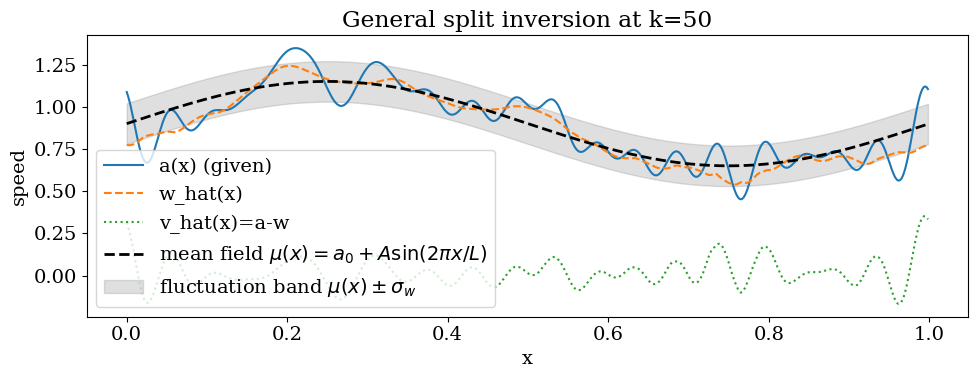

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# ============================================================
# Assumptions you said to use:
# - a_adv is precomputed and available (N,)
# - u_hist_tensor is available: either (N,M,K) or (M,N,K)
# - x_grid (N,), L, t_uniform
# - local POD bases are available as Vr_u_hist[k] (N,r) for each k (optional but used for drift)
# ============================================================


# ------------------------------------------------------------
# Periodic linear interpolation on uniform grid [0,L)
# ------------------------------------------------------------
def interp_periodic_on_grid(values_on_grid, xq, L):
    v = np.asarray(values_on_grid)
    xq = np.mod(np.asarray(xq), L)
    N = v.size
    dx = L / N
    i0 = np.floor(xq / dx).astype(int) % N
    frac = (xq - i0 * dx) / dx
    return (1 - frac) * v[i0] + frac * v[(i0 + 1) % N]


# ------------------------------------------------------------
# Departure points driven by w(x) only
# Backward-Euler in space: x_dep = x_arr - dt * w(x_dep)
# ------------------------------------------------------------
def departure_points_BE_from_wvec(w_vec, x_arr, dt, L, n_iter=40, tol=1e-12):
    x_arr = np.asarray(x_arr)

    # initial guess: explicit backtrace
    w_at_x = interp_periodic_on_grid(w_vec, x_arr, L)
    xdep = (x_arr - dt * w_at_x) % L

    for _ in range(n_iter):
        w_at_xdep = interp_periodic_on_grid(w_vec, xdep, L)
        xnew = (x_arr - dt * w_at_xdep) % L
        if np.max(np.abs(xnew - xdep)) < tol:
            xdep = xnew
            break
        xdep = xnew
    return xdep


# ------------------------------------------------------------
# Apply T_k(w) to snapshot matrix Uk (supports (N,M) or (M,N))
# Also works for bases Vk of shape (N,r)
# ------------------------------------------------------------
def apply_shift_to_snapshots(Uk, x_dep, L):
    Uk = np.asarray(Uk)
    x_dep = np.asarray(x_dep)

    # (N,M) or (N,r)
    if Uk.shape[0] == x_dep.size:
        N, M = Uk.shape
        TUk = np.empty_like(Uk)
        for m in range(M):
            TUk[:, m] = interp_periodic_on_grid(Uk[:, m], x_dep, L)
        return TUk

    # (M,N)
    if Uk.shape[1] == x_dep.size:
        M, N = Uk.shape
        TUk = np.empty_like(Uk)
        for m in range(M):
            TUk[m, :] = interp_periodic_on_grid(Uk[m, :], x_dep, L)
        return TUk

    raise ValueError(f"Uk shape {Uk.shape} incompatible with x_dep length {x_dep.size}")


# ------------------------------------------------------------
# First-order periodic upwind derivative (vectorized)
# direction uses s_vec (here: w_vec)
# ------------------------------------------------------------
def dudx_upwind1(u, s_vec, dx):
    u = np.asarray(u)
    s_vec = np.asarray(s_vec)

    u_im1 = np.roll(u,  1)
    u_ip1 = np.roll(u, -1)

    du_back = (u - u_im1) / dx
    du_forw = (u_ip1 - u) / dx

    return np.where(s_vec >= 0.0, du_back, du_forw)


# ------------------------------------------------------------
# H^1 periodic smoothness penalty: ||Dw||_2^2
# ------------------------------------------------------------
def H1_penalty(vec, dx):
    d = (np.roll(vec, -1) - vec) / dx
    return np.sum(d**2) * dx


# ------------------------------------------------------------
# Forward one-step predictor using general split:
#   a = w + v,  v = a - w
# Rewrite: D_w u / Dt = - v u_x
#
# Discretization (first-order, explicit RHS):
#   x_dep from w only (semi-Lagrangian)
#   u_{k+1}(x_i) ≈ u_k(x_dep) - dt * v(x_dep) * (u_x)_k(x_dep)
#
# u_x computed on Eulerian grid using upwind direction from w, then shifted to x_dep.
# ------------------------------------------------------------
def predict_Ukp1_from_w(Uk, x_grid, L, dt, a_adv, w_vec):
    x_grid = np.asarray(x_grid)
    N = x_grid.size
    dx = L / N

    a_adv = np.asarray(a_adv)
    w_vec = np.asarray(w_vec)
    v_vec = a_adv - w_vec

    # departure points depend only on w
    x_dep = departure_points_BE_from_wvec(w_vec, x_grid, dt, L)

    # transport part: u_k(x_dep)
    TUk = apply_shift_to_snapshots(Uk, x_dep, L)

    # compute u_x on Eulerian grid, direction uses w_vec, then shift to x_dep
    if Uk.shape[0] == N:  # (N,M)
        N, M = Uk.shape
        dUk = np.empty_like(Uk)
        for m in range(M):
            dUk[:, m] = dudx_upwind1(Uk[:, m], w_vec, dx)
        TdUk = apply_shift_to_snapshots(dUk, x_dep, L)  # (N,M)
        v_at_dep = interp_periodic_on_grid(v_vec, x_dep, L)[:, None]  # (N,1)
        Ukp1_hat = TUk - dt * (v_at_dep * TdUk)
        return Ukp1_hat, x_dep

    else:  # (M,N)
        M, N2 = Uk.shape
        assert N2 == N
        dUk = np.empty_like(Uk)
        for m in range(M):
            dUk[m, :] = dudx_upwind1(Uk[m, :], w_vec, dx)
        TdUk = apply_shift_to_snapshots(dUk, x_dep, L)  # (M,N)
        v_at_dep = interp_periodic_on_grid(v_vec, x_dep, L)[None, :]  # (1,N)
        Ukp1_hat = TUk - dt * (v_at_dep * TdUk)
        return Ukp1_hat, x_dep


# ------------------------------------------------------------
# Objective over w_vec for a single k:
#   J(w) = ||U_{k+1} - Uhat_{k+1}(w)||_F^2 + lam_H1 * ||D w||^2
# ------------------------------------------------------------
def objective_wvec(w_vec, Uk, Ukp1, x_grid, L, dt, a_adv, lam_H1):
    N = x_grid.size
    dx = L / N
    Ukp1_hat, _ = predict_Ukp1_from_w(Uk, x_grid, L, dt, a_adv, w_vec)
    misfit2 = np.linalg.norm(Ukp1 - Ukp1_hat, ord="fro")**2
    reg = lam_H1 * H1_penalty(w_vec, dx)
    return misfit2 + reg


# ------------------------------------------------------------
# Interpolated subspace drift:
#   Given bases Vk, Vkp1 (N,r), define S = T_k(w) Vk (interpolated via x_dep)
#   Drift: E = || (I - Pkp1) S ||_F,  Pkp1 = Vkp1 Vkp1^T
# ------------------------------------------------------------
def interpolated_subspace_drift(Vk, Vkp1, x_grid, L, dt, w_vec):
    Vk = np.asarray(Vk)
    Vkp1 = np.asarray(Vkp1)
    N = x_grid.size

    # departure points depend only on w
    x_dep = departure_points_BE_from_wvec(w_vec, x_grid, dt, L)

    # shift basis columns (N,r)
    S_Vk = apply_shift_to_snapshots(Vk, x_dep, L)  # (N,r)

    # project error wrt next basis
    Pkp1 = Vkp1 @ Vkp1.T
    I = np.eye(N)
    E = np.linalg.norm((I - Pkp1) @ S_Vk, ord="fro")

    # also useful: alignment norm || Vkp1^T S_Vk ||_F
    align = np.linalg.norm(Vkp1.T @ S_Vk, ord="fro")
    return float(E), float(align)


# ------------------------------------------------------------
# Single-k inversion for w(x) (vector) with bounds
# ------------------------------------------------------------
def invert_w_single_k(
    k_solve,
    u_hist_tensor, x_grid, L, t_uniform,
    a_adv,
    w_init=None,
    w_bounds=(0.0, 3.0),
    lam_H1=1e-2,
    maxiter=40,
    ftol=1e-10,
    Vr_u_hist=None,   # pass list of bases if you want drift printed
    verbose=True
):
    K = u_hist_tensor.shape[2]
    if not (0 <= k_solve <= K - 2):
        raise ValueError(f"k_solve must be in [0, {K-2}], got {k_solve}")

    N = x_grid.size
    dt = float(t_uniform[1] - t_uniform[0])

    Uk = u_hist_tensor[:, :, k_solve]
    Ukp1 = u_hist_tensor[:, :, k_solve + 1]

    if w_init is None:
        # a simple default: start from w=a (i.e., v=0)
        w_init = np.asarray(a_adv, dtype=float).copy()
    else:
        w_init = np.asarray(w_init, dtype=float).copy()

    bounds = [w_bounds] * N

    res = minimize(
        objective_wvec,
        x0=w_init,
        args=(Uk, Ukp1, x_grid, L, dt, a_adv, lam_H1),
        method="L-BFGS-B",
        bounds=bounds,
        jac="2-point",
        options={"maxiter": maxiter, "ftol": ftol}
    )

    w_hat = res.x

    # --- diagnostics ---
    Ukp1_hat, _ = predict_Ukp1_from_w(Uk, x_grid, L, dt, a_adv, w_hat)
    misfit_F = np.linalg.norm(Ukp1 - Ukp1_hat, ord="fro")
    misfit_F2 = misfit_F**2

    drift = None
    align = None
    if Vr_u_hist is not None:
        Vk = Vr_u_hist[k_solve]
        Vkp1 = Vr_u_hist[k_solve + 1]
        drift, align = interpolated_subspace_drift(Vk, Vkp1, x_grid, L, dt, w_hat)

    if verbose:
        print(f"[single-k w] k={k_solve} | success={res.success} | iters={res.nit} | J={res.fun:.3e}")
        print(f"  data misfit ||Ukp1 - Uhat||_F   = {misfit_F:.6e}")
        print(f"  data misfit ||Ukp1 - Uhat||_F^2 = {misfit_F2:.6e}")
        if drift is not None:
            print(f"  interpolated subspace drift E   = {drift:.6e}")
            print(f"  interpolated subspace align     = {align:.6e}")

    return w_hat, res


# ============================
# DEMO USAGE (single k)
# ============================

k_solve = 50  # change freely

# Initial guess for w: you can use a_adv or something smoother
w_init = a_adv.copy()

w_hat_k, res = invert_w_single_k(
    k_solve=k_solve,
    u_hist_tensor=u_hist_tensor,
    x_grid=x_grid,
    L=L,
    t_uniform=t_uniform,
    a_adv=a_adv,
    w_init=w_init,
    w_bounds=(0.0, 3.0),
    lam_H1=5e-3,
    maxiter=20,       # keep small to test quickly
    ftol=1e-10,
    Vr_u_hist=Vr_u_hist,   # set to None if you don't want drift
    verbose=True
)

# Plot w_hat and the implied v_hat = a - w
plt.figure(figsize=(10,4))
plt.plot(x_grid, a_adv, label="a(x) (given)")
plt.plot(x_grid, w_hat_k, "--", label="w_hat(x)")
plt.plot(x_grid, a_adv - w_hat_k, ":", label="v_hat(x)=a-w")
plt.title(f"General split inversion at k={k_solve}")
# --- mean field from construction ---
a_mean_field = a0 + amp_sine * np.sin(2*np.pi * x_grid / L)

plt.plot(
    x_grid,
    a_mean_field,
    "k--",
    lw=2.0,
    label=r"mean field $\mu(x)=a_0 + A\sin(2\pi x/L)$"
)

# --- variance (std) band from stochastic construction ---
plt.fill_between(
    x_grid,
    a_mean_field - sigma_w,
    a_mean_field + sigma_w,
    color="gray",
    alpha=0.25,
    label=r"fluctuation band $\mu(x)\pm\sigma_w$"
)

plt.xlabel("x")
plt.ylabel("speed")
plt.legend()
plt.tight_layout()
plt.show()


# Dump


In [ ]:

# ----------------------------
# Run ALL simulations (simple loop; you can swap joblib here if you want)
# This produces u_hist_tensor: (N, M, nt_uniform) for your POD workflow
# ----------------------------
u_uniform_list = []
t_hist_list = []
U_hist_list = []
dt_hist_list = []

print(f"Running {M} simulations (RK4 + upwind + CFL dt)...")
for m in range(M):
    u_uniform, t_hist_np, U_hist_np, dt_hist_np = run_single_simulation(
        u0_mat[:, m],
        x_grid,
        a_adv,
        CFL, dx, tEnd, t_uniform,
        eps
    )
    u_uniform_list.append(u_uniform)
    t_hist_list.append(t_hist_np)
    U_hist_list.append(U_hist_np)
    dt_hist_list.append(dt_hist_np)

print("Completed simulations.")

# Stack into tensor: (N, M, nt_uniform)
u_hist_tensor = np.stack(u_uniform_list, axis=1).astype(np.float64)
print("u_hist_tensor shape:", u_hist_tensor.shape)  # (N, M, nt_uniform)


# ----------------------------
# Sanity plots: a(x), a few ICs, and snapshots for IC 0
# ----------------------------
plt.figure(figsize=(7.5,4))
plt.plot(x_grid, a_adv)
plt.title("Static Gaussian advection speed a_adv(x)")
plt.xlabel("x"); plt.ylabel("a(x)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4.5))
for m in [0, 1, 2, 3]:
    plt.plot(x_grid, u0_mat[:, m], label=f"IC {m}")
plt.title("Sample initial conditions u0(x)")
plt.xlabel("x"); plt.ylabel("u0")
plt.legend()
plt.tight_layout()
plt.show()

ic0 = 0
snap_ts = [0.0, 0.25, 0.5, 0.75, 1.0]
snap_idx = [int(np.argmin(np.abs(t_uniform - tt))) for tt in snap_ts]

plt.figure(figsize=(8,4.5))
for tt, si in zip(snap_ts, snap_idx):
    plt.plot(x_grid, u_hist_tensor[:, ic0, si], label=f"t={t_uniform[si]:.2f}")
plt.title("IC 0: solution snapshots u(t,x)")
plt.xlabel("x"); plt.ylabel("u")
plt.legend(ncol=2)
plt.tight_layout()
plt.show()


# ----------------------------
# Local compression check at time index it0 (template uses 400)
# ----------------------------
it0 = 400
u_local = u_hist_tensor[:, :, it0]  # (N,M)
r_ulocal, U_ulocal, S_ulocal = svd_energy_rank(u_local, energy=0.9999)

print("\nLocal compression check:")
print(f"  it0={it0}, t={t_uniform[it0]:.4f}")
print("  rank for 99.99% energy:", float(r_ulocal))

plt.figure(figsize=(7,4))
plt.semilogy(S_ulocal, lw=1.6)
plt.title(f"Singular values of u_local at t={t_uniform[it0]:.3f}")
plt.xlabel("index")
plt.ylabel("singular value")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()


# ----------------------------
# POD bases over time + subspace drift (template style)
# Doing SVD at every time step can be heavy.
# Use pod_stride=1 for full (500 SVDs), or 5/10 for speed.
# ----------------------------
def subspace_drift(V_hist):
    """
    Compute subspace misalignment between consecutive POD bases.
    Returns E_minus, E_plus arrays of length nt_hist.
    """
    nt = len(V_hist)
    E_minus = np.zeros(nt)
    E_plus  = np.zeros(nt)
    I = np.eye(V_hist[0].shape[0], dtype=V_hist[0].dtype)

    for i in range(nt):
        V_curr = V_hist[i]

        if i > 0:
            V_prev = V_hist[i - 1]
            P_prev = V_prev @ V_prev.T
            E_minus[i] = np.linalg.norm((I - P_prev) @ V_curr, 'fro')
        else:
            E_minus[i] = np.nan

        if i < nt - 1:
            V_next = V_hist[i + 1]
            P_next = V_next @ V_next.T
            E_plus[i] = np.linalg.norm((I - P_next) @ V_curr, 'fro')
        else:
            E_plus[i] = np.nan

    return E_minus, E_plus

r = 30
pod_stride = 5   # <-- set 1 to match template exactly; 5 is much faster
time_ids = np.arange(0, nt_uniform, pod_stride)

Vr_u_hist = []

print(f"\nComputing POD bases every {pod_stride} time steps (total {len(time_ids)} SVDs)...")
for it in time_ids:
    u_local = u_hist_tensor[:, :, it]  # (N,M)
    Uu, Su, _ = np.linalg.svd(u_local, full_matrices=False)
    Vr_u = Uu[:, :r]
    Vr_u_hist.append(Vr_u)

Eminus_u, Eplus_u = subspace_drift(Vr_u_hist)

plt.figure(figsize=(8,4))
plt.semilogy(Eminus_u, lw=1.4, label=r"using the previous time step $(i-1)$")
plt.xlabel("POD time index (compressed)")
plt.ylabel("Subspace drift (Fro norm)")
plt.title(rf"Subspace drift for $u$ (rank r={r}, stride={pod_stride})")
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print("\nDone.")
